Trabajo Data Science: Kiran Dhillon, Sergi Moros, Sara Requena, Julià Mestieri

Dataset: https://www.kaggle.com/unsdsn/world-happiness

## Carga de datos

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import pycountry
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, r2_score

In [2]:
years = [2015, 2016, 2017, 2018, 2019]
ds_15 = pd.read_csv('data/2015.csv').drop(['Standard Error'],axis=1)
ds_15.rename(columns={"Happiness Rank": "Rank","Happiness Score":"Score","Economy (GDP per Capita)":"GDP","Family":"Social support","Health (Life Expectancy)":"Healthy","Trust (Government Corruption)":"Trust"},inplace=True)  
ds_15.insert(0, "Year", 2015)
ds_15['Rounded Score'] = ds_15['Score'].round(0)

ds_16 = pd.read_csv('data/2016.csv').drop(['Lower Confidence Interval','Upper Confidence Interval'],axis=1)
ds_16.rename(columns={"Happiness Rank": "Rank","Happiness Score":"Score","Economy (GDP per Capita)":"GDP","Family":"Social support","Health (Life Expectancy)":"Healthy","Trust (Government Corruption)":"Trust"},inplace=True) 
ds_16.insert(0, "Year", 2016)
ds_16['Rounded Score'] = ds_16['Score'].round(0)

ds_17 = pd.read_csv('data/2017.csv').drop(['Whisker.high','Whisker.low'],axis=1)
ds_17.rename(columns={"Happiness.Rank": "Rank","Happiness.Score":"Score","Economy..GDP.per.Capita.":"GDP","Family":"Social support","Health..Life.Expectancy.":"Healthy","Trust..Government.Corruption.":"Trust","Dystopia.Residual":"Dystopia Residual"},inplace=True) 
ds_17.insert(0, "Year", 2017)
ds_17 = ds_17.join(ds_15.set_index('Country')['Region'], on='Country')
ds_17['Rounded Score'] = ds_17['Score'].round(0)

ds_18 = pd.read_csv('data/2018.csv')
ds_18.rename(columns={"Country or region": "Country", "Overall rank": "Rank","Score":"Score","GDP per capita":"GDP","Healthy life expectancy":"Healthy","Freedom to make life choices":"Freedom","Perceptions of corruption":"Trust"},inplace=True)
ds_18.insert(0, "Year", 2018)
ds_18 = ds_18.join(ds_15.set_index('Country')['Region'], on='Country')
ds_18['Rounded Score'] = ds_18['Score'].round(0)

ds_19 = pd.read_csv('data/2019.csv')
ds_19.rename(columns={"Country or region": "Country", "Overall rank": "Rank","GDP per capita":"GDP","Healthy life expectancy":"Healthy","Freedom to make life choices":"Freedom","Perceptions of corruption":"Trust"},inplace=True)
ds_19.insert(0, "Year", 2019)
ds_19 = ds_19.join(ds_15.set_index('Country')['Region'], on='Country')
ds_19['Rounded Score'] = ds_19['Score'].round(0)

df = pd.concat([ds_15, ds_16, ds_17, ds_18, ds_19], sort=True, ignore_index=True)

df

Country  Dystopia Residual  Freedom      GDP  \
0                 Switzerland            2.51738  0.66557  1.39651   
1                     Iceland            2.70201  0.62877  1.30232   
2                     Denmark            2.49204  0.64938  1.32548   
3                      Norway            2.46531  0.66973  1.45900   
4                      Canada            2.45176  0.63297  1.32629   
..                        ...                ...      ...      ...   
777                    Rwanda                NaN  0.55500  0.35900   
778                  Tanzania                NaN  0.41700  0.47600   
779               Afghanistan                NaN  0.00000  0.35000   
780  Central African Republic                NaN  0.22500  0.02600   
781               South Sudan                NaN  0.01000  0.30600   

     Generosity  Healthy  Rank              Region  Rounded Score  Score  \
0       0.29678  0.94143     1      Western Europe            8.0  7.587   
1       0.43630  0.94784     2      Western Europe            8.0  7.561   
2       0.34139  0.87464     3      Western Europe            8.0  7.527   
3       0.34699  0.88521     4      Western Europe            8.0  7.522   
4       0.45811  0.90563     5       North America            7.0  7.427   
..          ...      ...   ...                 ...            ...    ...   
777     0.21700  0.61400   152  Sub-Saharan Africa            3.0  3.334   
778     0.27600  0.49900   153  Sub-Saharan Africa            3.0  3.231   
779     0.15800  0.36100   154       Southern Asia            3.0  3.203   
780     0.23500  0.10500   155  Sub-Saharan Africa            3.0  3.083   
781     0.20200  0.29500   156                 NaN            3.0  2.853   

     Social support    Trust  Year  
0           1.34951  0.41978  2015  
1           1.40223  0.14145  2015  
2           1.36058  0.48357  2015  
3           1.33095  0.36503  2015  
4           1.32261  0.32957  2015  
..              ...      ...   ...  
777         0.71100  0.41100  2019  
778         0.88500  0.14700  2019  
779         0.51700  0.02500  2019  
780         0.00000  0.03500  2019  
781         0.57500  0.09100  2019  

[782 rows x 13 columns]

In [3]:
""" Adding external data. """
####
# IMPORTANTE: wdidata no cabe en github, se debe descargar de: https://datacatalog.worldbank.org/dataset/world-development-indicators
# y mover al directorio 'data'
####
edf = pd.read_csv('data/wdidata.csv')

In [4]:
df['Mujeres trab.agricultura'] = np.nan
df['GDP por trabajador'] = np.nan
df['Participación lab.1524'] = np.nan
df['Mujeres trab.servicios'] = np.nan
df['Mujeres desempleadas'] = np.nan
df['Hombres mas 80'] = np.nan
df['Trasporte aereo'] = np.nan
df['Mujeres desempleadas.1524'] = np.nan
df['Ratio dif empleo genero'] = np.nan
df['Refugiados'] = np.nan

for index, row in df.iterrows():
    country_name = row['Country']
    year = row['Year']
    if year in years:
        mujeres_campo = edf.loc[(edf['Country Name'] == country_name) & (edf['Indicator Code'] == 'SL.AGR.EMPL.FE.ZS')][str(year)]
        if mujeres_campo.values.size > 0:
            df.at[index, 'Mujeres trab.agricultura'] = mujeres_campo.values[0]
        gdp_por_trab = edf.loc[(edf['Country Name'] == country_name) & (edf['Indicator Code'] == 'SL.GDP.PCAP.EM.KD')][str(year)]
        if gdp_por_trab.values.size > 0:
            df.at[index, 'GDP por trabajador'] = gdp_por_trab.values[0]
        participacion = edf.loc[(edf['Country Name'] == country_name) & (edf['Indicator Code'] == 'SL.TLF.ACTI.1524.FE.ZS')][str(year)]
        if participacion.values.size > 0:
            df.at[index, 'Participación lab.1524'] = participacion.values[0]
        muj_trab_ser = edf.loc[(edf['Country Name'] == country_name) & (edf['Indicator Code'] == 'SL.SRV.EMPL.FE.ZS')][str(year)]
        if muj_trab_ser.values.size > 0:
            df.at[index, 'Mujeres trab.servicios'] = muj_trab_ser.values[0]
        muj_des = edf.loc[(edf['Country Name'] == country_name) & (edf['Indicator Code'] == 'SL.UEM.TOTL.FE.ZS')][str(year)]
        if muj_des.values.size > 0:
            df.at[index, 'Mujeres desempleadas'] = muj_des.values[0]
        hom_up_80 = edf.loc[(edf['Country Name'] == country_name) & (edf['Indicator Code'] == 'SP.POP.80UP.MA.5Y')][str(year)]
        if hom_up_80.values.size > 0:
            df.at[index, 'Hombres mas 80'] = hom_up_80.values[0]
        trans_aereo = edf.loc[(edf['Country Name'] == country_name) & (edf['Indicator Code'] == 'IS.AIR.DPRT')][str(year)]
        if trans_aereo.values.size > 0:
            df.at[index, 'Transporte aereo'] = trans_aereo.values[0]
        muj_desem = edf.loc[(edf['Country Name'] == country_name) & (edf['Indicator Code'] == 'SL.UEM.1524.FE.ZS')][str(year)]
        if muj_desem.values.size > 0:
            df.at[index, 'Mujeres desempleadas.1524'] = muj_desem.values[0]
        diff_gen = edf.loc[(edf['Country Name'] == country_name) & (edf['Indicator Code'] == 'SL.TLF.CACT.FM.ZS')][str(year)]
        if diff_gen.values.size > 0:
            df.at[index, 'Ratio dif empleo genero'] = diff_gen.values[0]
        refug = edf.loc[(edf['Country Name'] == country_name) & (edf['Indicator Code'] == 'SM.POP.REFG.OR')][str(year)]
        if refug.values.size > 0:
            df.at[index, 'Refugiados'] = refug.values[0]

df

Country  Dystopia Residual  Freedom      GDP  \
0                 Switzerland            2.51738  0.66557  1.39651   
1                     Iceland            2.70201  0.62877  1.30232   
2                     Denmark            2.49204  0.64938  1.32548   
3                      Norway            2.46531  0.66973  1.45900   
4                      Canada            2.45176  0.63297  1.32629   
..                        ...                ...      ...      ...   
777                    Rwanda                NaN  0.55500  0.35900   
778                  Tanzania                NaN  0.41700  0.47600   
779               Afghanistan                NaN  0.00000  0.35000   
780  Central African Republic                NaN  0.22500  0.02600   
781               South Sudan                NaN  0.01000  0.30600   

     Generosity  Healthy  Rank              Region  Rounded Score  Score  ...  \
0       0.29678  0.94143     1      Western Europe            8.0  7.587  ...   
1       0.43630  0.94784     2      Western Europe            8.0  7.561  ...   
2       0.34139  0.87464     3      Western Europe            8.0  7.527  ...   
3       0.34699  0.88521     4      Western Europe            8.0  7.522  ...   
4       0.45811  0.90563     5       North America            7.0  7.427  ...   
..          ...      ...   ...                 ...            ...    ...  ...   
777     0.21700  0.61400   152  Sub-Saharan Africa            3.0  3.334  ...   
778     0.27600  0.49900   153  Sub-Saharan Africa            3.0  3.231  ...   
779     0.15800  0.36100   154       Southern Asia            3.0  3.203  ...   
780     0.23500  0.10500   155  Sub-Saharan Africa            3.0  3.083  ...   
781     0.20200  0.29500   156                 NaN            3.0  2.853  ...   

     GDP por trabajador  Participación lab.1524  Mujeres trab.servicios  \
0         103602.585938               68.313004               87.030998   
1          75040.609375               81.785004               91.330002   
2          94613.531250               62.389999               89.277000   
3         125677.398438               56.618000               91.870003   
4          84005.359375               64.448997               90.433998   
..                  ...                     ...                     ...   
777         4223.943848               63.733002               25.662001   
778         6497.994141               69.106003               29.461000   
779         6984.897949               20.403999               10.079000   
780         2048.333984               52.889000               15.996000   
781         4464.730957               63.477001               18.926001   

     Mujeres desempleadas  Hombres mas 80  Trasporte aereo  \
0                   4.912        3.705261              NaN   
1                   4.051        3.029846              NaN   
2                   6.444        3.218882              NaN   
3                   3.999        3.129684              NaN   
4                   6.285        3.270799              NaN   
..                    ...             ...              ...   
777                 1.070             NaN              NaN   
778                 2.462             NaN              NaN   
779                14.004             NaN              NaN   
780                 3.565             NaN              NaN   
781                13.406             NaN              NaN   

     Mujeres desempleadas.1524  Ratio dif empleo genero  Refugiados  \
0                     8.390000                84.080678        17.0   
1                     6.638000                90.302418         NaN   
2                    10.027000                86.857312         9.0   
3                     8.565000                89.632442        12.0   
4                    11.228000                86.295118        80.0   
..                         ...                      ...         ...   
777                   2.157000               100.684972         N

## EDA: Estudio y Visualización de los datos


/usr/lib/python3/dist-packages/numpy/lib/histograms.py:824: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/usr/lib/python3/dist-packages/numpy/lib/histograms.py:825: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


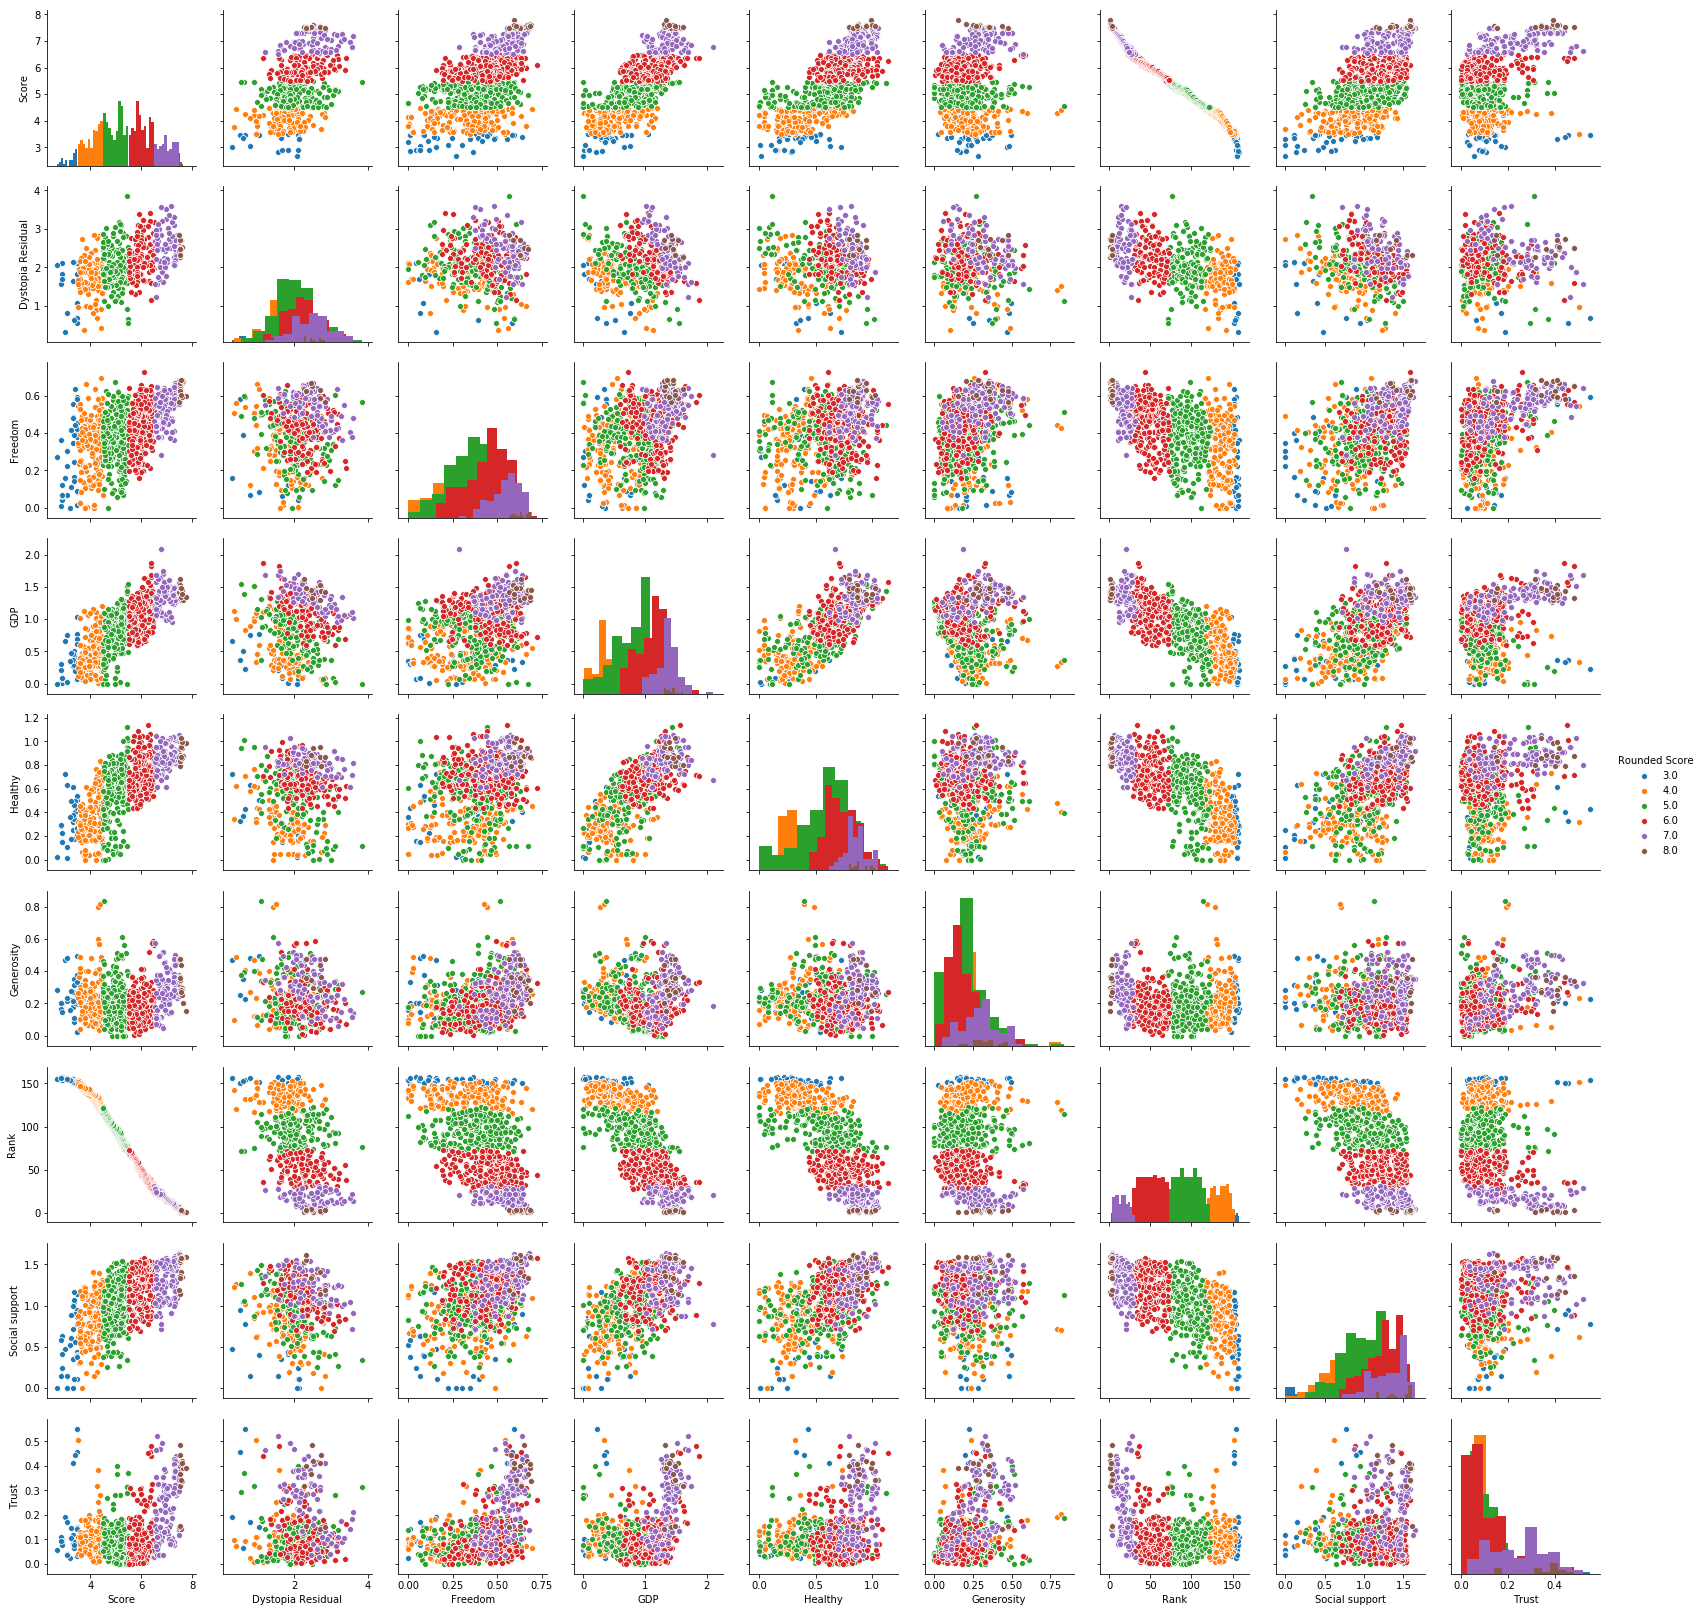

In [5]:
# https://towardsdatascience.com/visualizing-data-with-pair-plots-in-python-f228cf529166
# variables Kaggle
sns.pairplot(df, diag_kind='hist', hue='Rounded Score', vars=['Score','Dystopia Residual','Freedom','GDP','Healthy','Generosity','Rank','Social support','Trust'])

/usr/lib/python3/dist-packages/numpy/lib/histograms.py:824: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/usr/lib/python3/dist-packages/numpy/lib/histograms.py:825: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


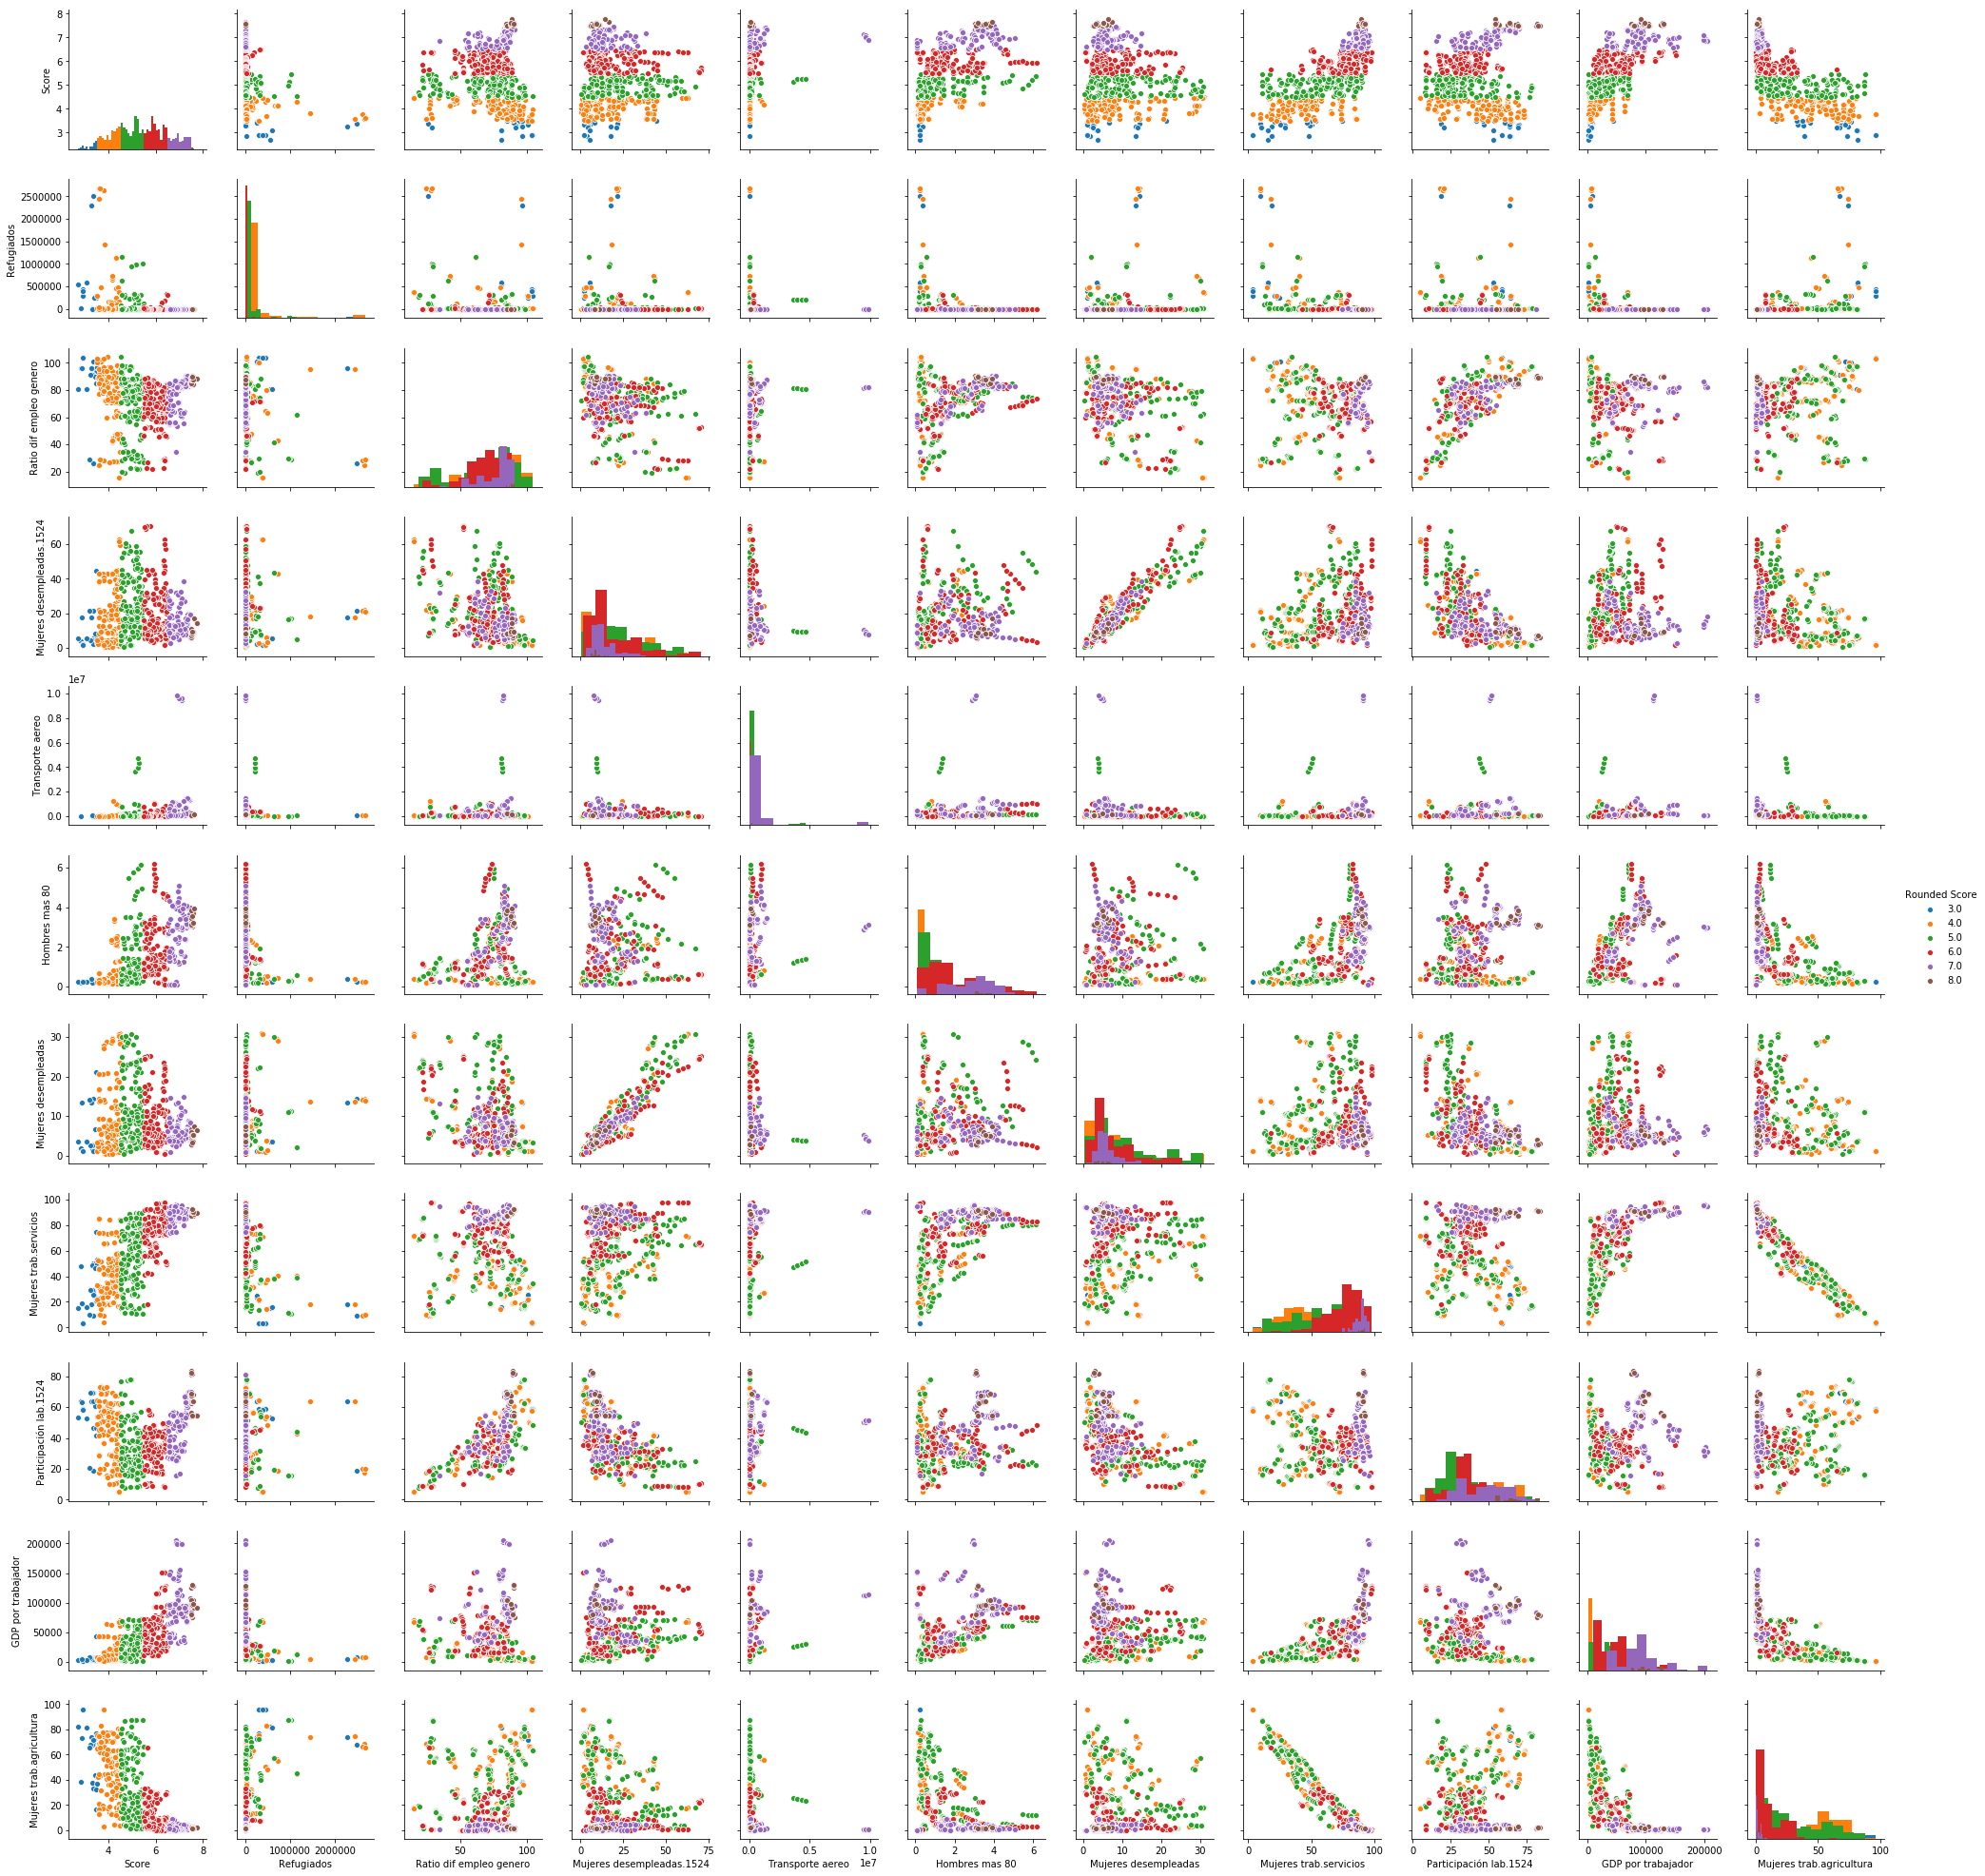

In [51]:
# variables World Bank
sns.pairplot(df, diag_kind='hist', hue='Rounded Score', vars=['Score','Refugiados','Ratio dif empleo genero','Mujeres desempleadas.1524','Transporte aereo','Hombres mas 80','Mujeres desempleadas','Mujeres trab.servicios', 'Participación lab.1524','GDP por trabajador', 'Mujeres trab.agricultura'])

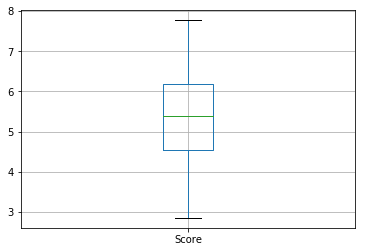

In [6]:
ds_19.boxplot('Score')

In [7]:
# Correlation https://towardsdatascience.com/exploratory-data-analysis-eda-visualization-using-pandas-ca5a04271607
df.corr()

Dystopia Residual   Freedom       GDP  Generosity  \
Dystopia Residual                   1.000000  0.038422  0.030087   -0.114468   
Freedom                             0.038422  1.000000  0.340511    0.290706   
GDP                                 0.030087  0.340511  1.000000   -0.014560   
Generosity                         -0.114468  0.290706 -0.014560    1.000000   
Healthy                             0.057674  0.340745  0.784338    0.010638   
Rank                               -0.482706 -0.537942 -0.794791   -0.117713   
Rounded Score                       0.496164  0.526308  0.751198    0.120716   
Score                               0.489747  0.551258  0.789284    0.137578   
Social support                     -0.081537  0.420361  0.585966   -0.037262   
Trust                               0.000001  0.459593  0.306307    0.318920   
Year                               -0.177951  0.010353  0.019768   -0.192587   
Mujeres trab.agricultura           -0.145036 -0.335868 -0.810426    0.050567   
GDP por trabajador                  0.039140  0.354584  0.871926    0.082896   
Participación lab.1524             -0.021286  0.274788 -0.149250    0.352215   
Mujeres trab.servicios              0.167129  0.350941  0.819297   -0.019506   
Mujeres desempleadas               -0.053304 -0.365352  0.086647   -0.346545   
Hombres mas 80                      0.076045  0.196062  0.636327   -0.016758   
Trasporte aereo                          NaN       NaN       NaN         NaN   
Mujeres desempleadas.1524          -0.062146 -0.273544  0.186743   -0.329513   
Ratio dif empleo genero            -0.123672  0.129057 -0.091070    0.137222   
Refugiados                         -0.013547 -0.229900 -0.278939    0.119599   
Transporte aereo                    0.073710  0.129363  0.207766    0.100878   

                            Healthy      Rank  Rounded Score     Score  \
Dystopia Residual          0.057674 -0.482706       0.496164  0.489747   
Freedom                    0.340745 -0.537942       0.526308  0.551258   
GDP                        0.784338 -0.794791       0.751198  0.789284   
Generosity                 0.010638 -0.117713       0.120716  0.137578   
Healthy                    1.000000 -0.743655       0.700832  0.742456   
Rank                      -0.743655  1.000000      -0.958419 -0.992066   
Rounded Score              0.700832 -0.958419       1.000000  0.966224   
Score                      0.742456 -0.992066       0.966224  1.000000   
Social support             0.572650 -0.644842       0.615860  0.648799   
Trust                      0.250512 -0.372781       0.375974  0.398418   
Year                       0.130302 -0.007768      -0.021428  0.007065   
Mujeres trab.agricultura  -0.709805  0.740832      -0.708446 -0.732162   
GDP por trabajador         0.685699 -0.724311       0.700717  0.727041   
Participación lab.1524    -0.072653 -0.012978       0.046551  0.034903   
Mujeres trab.servicios     0.696151 -0.765997       0.734871  0.758913   
Mujeres desempleadas      -0.035482  0.136987      -0.138028 -0.131940   
Hombres mas 80             0.748967 -0.583901       0.564394  0.592967   
Trasporte aereo                 NaN       NaN            NaN       NaN   
Mujeres desempleadas.1524  0.082437  0.044047      -0.062363 -0.045776   
Ratio dif empleo genero   -0.080213  0.044456       0.001839 -0.034359   
Refugiados                -0.285942  0.268205      -0.267406 -0.275363   
Transporte aereo           0.198480 -0.212865       0.196978  0.219052   

                           Social support     Trust  ...  GDP por trabajador  \
Dystopia Residual               -0.081537  0.000001  ...            0.039140   
Freedom                          0.420361  0.459593  ...            0.354584   
GDP                              0.585966  0.306307  ...            0.871926   
Generosity                      -0.037262  0.318920  ...            0.082896   
Healthy                          0.572650  0.250512  ...            0.685699   
Ran

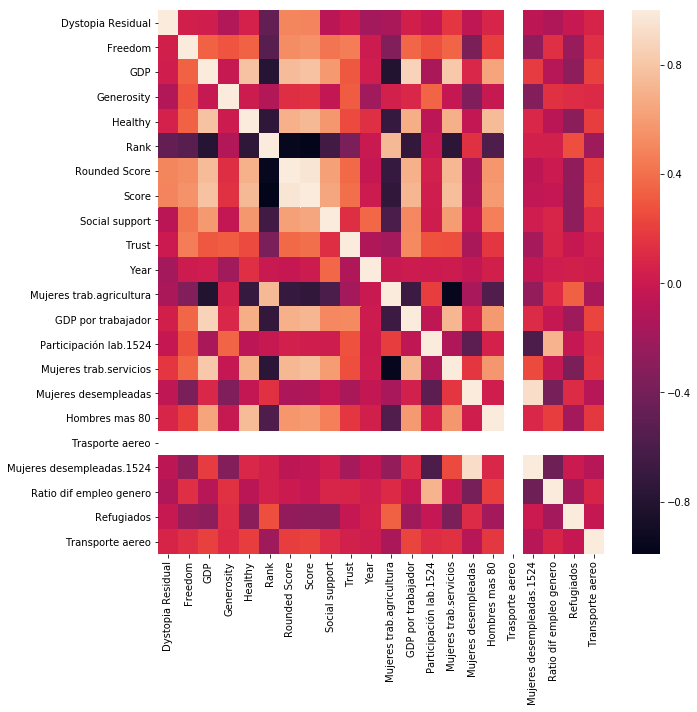

In [8]:
f,ax=plt.subplots(figsize=(10,10))
cor = df.corr() 
sns.heatmap(cor)

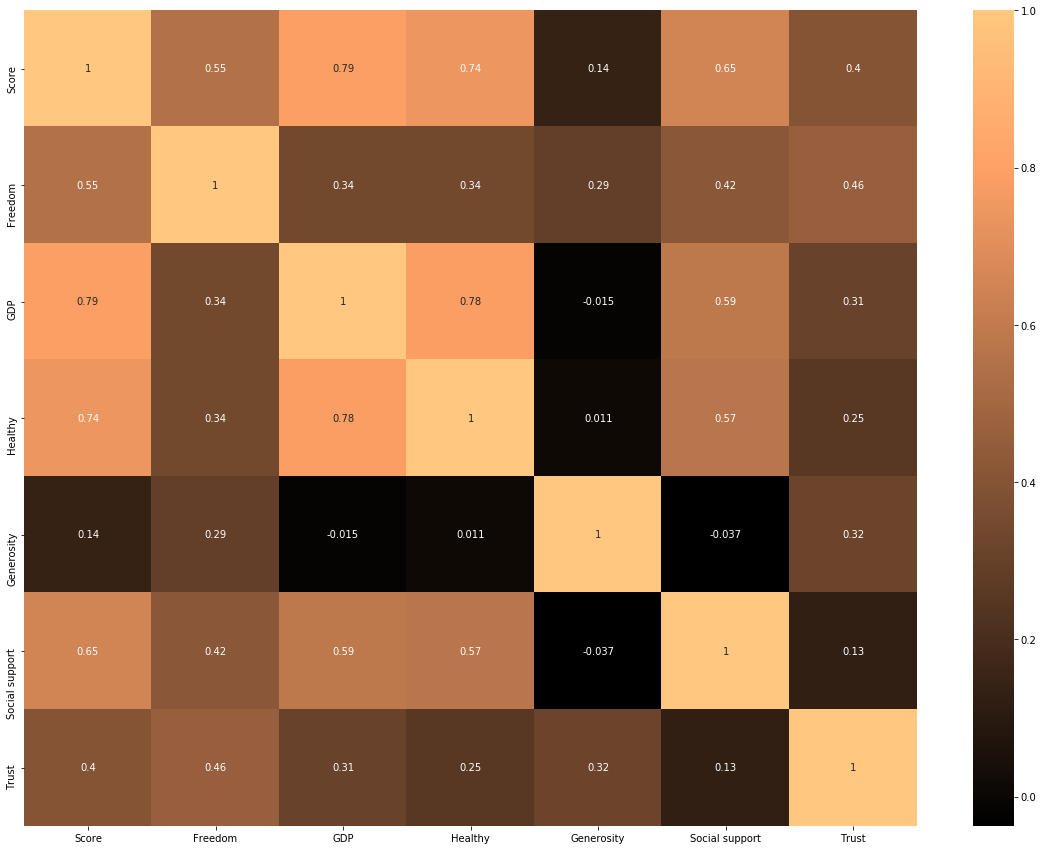

In [52]:
df_ini = df[['Score','Freedom','GDP','Healthy','Generosity','Social support','Trust']]
plt.rcParams['figure.figsize'] = (20, 15)
sns.heatmap(df_ini.corr(), cmap = 'copper', annot = True)

plt.show()

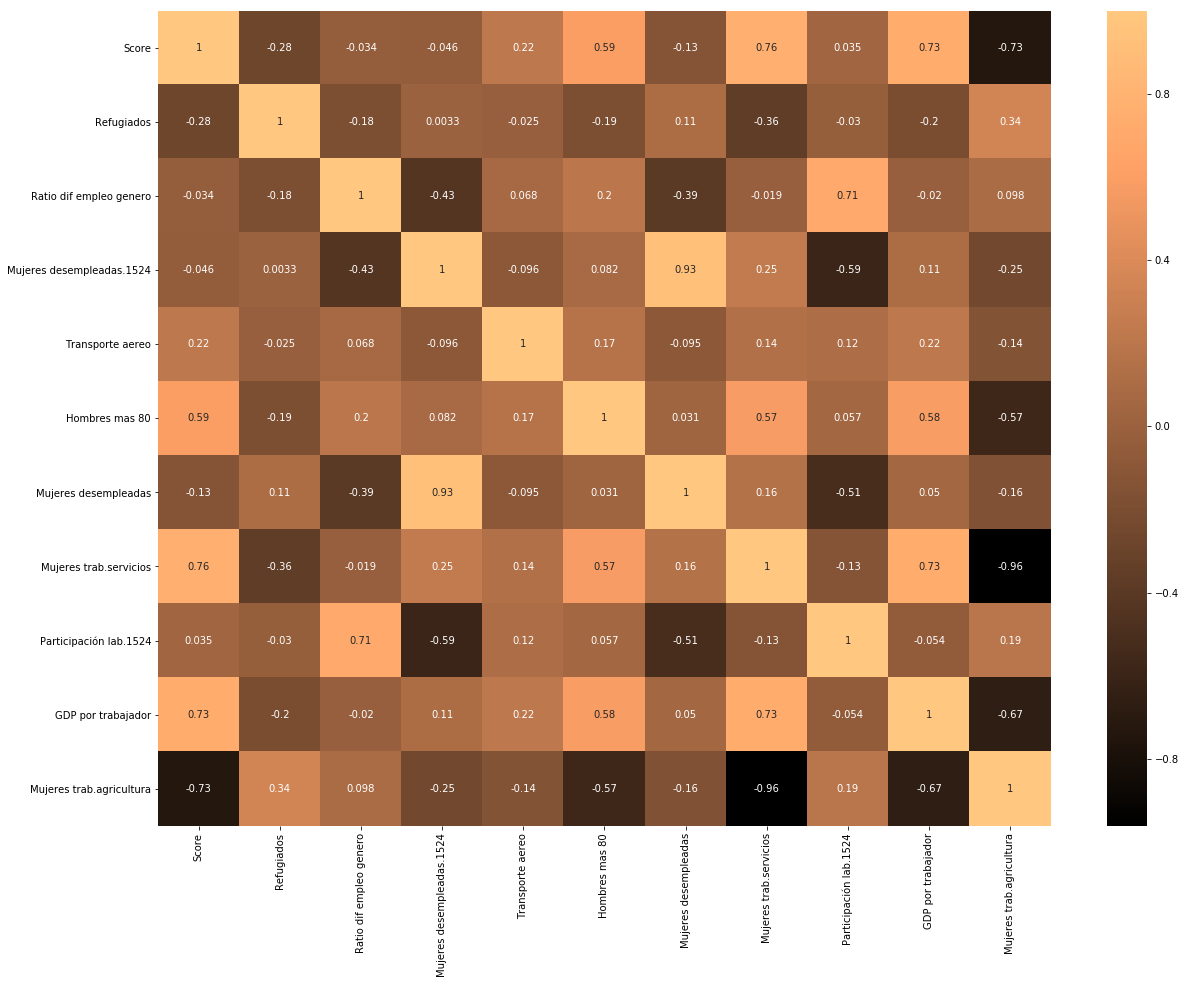

In [53]:
df_ext = df[['Score','Refugiados','Ratio dif empleo genero','Mujeres desempleadas.1524','Transporte aereo','Hombres mas 80','Mujeres desempleadas','Mujeres trab.servicios', 'Participación lab.1524','GDP por trabajador', 'Mujeres trab.agricultura']]
plt.rcParams['figure.figsize'] = (20, 15)
sns.heatmap(df_ext.corr(), cmap = 'copper', annot = True)

plt.show()

In [9]:
df.describe()

Dystopia Residual     Freedom         GDP  Generosity     Healthy  \
count         470.000000  782.000000  782.000000  782.000000  782.000000   
mean            2.092717    0.411091    0.916047    0.218576    0.612416   
std             0.565772    0.152880    0.407340    0.122321    0.248309   
min             0.328580    0.000000    0.000000    0.000000    0.000000   
25%             1.737975    0.309768    0.606500    0.130000    0.440183   
50%             2.094640    0.431000    0.982205    0.201982    0.647310   
75%             2.455575    0.531000    1.236187    0.278832    0.808000   
max             3.837720    0.724000    2.096000    0.838075    1.141000   

             Rank  Rounded Score       Score  Social support       Trust  ...  \
count  782.000000     782.000000  782.000000      782.000000  781.000000  ...   
mean    78.698210       5.358056    5.379018        1.078392    0.125436  ...   
std     45.182384       1.147142    1.127456        0.329548    0.105816  ...   
min      1.000000       3.000000    2.693000        0.000000    0.000000  ...   
25%     40.000000       5.000000    4.509750        0.869363    0.054000  ...   
50%     79.000000       5.000000    5.322000        1.124735    0.091000  ...   
75%    118.000000       6.000000    6.189500        1.327250    0.156030  ...   
max    158.000000       8.000000    7.769000        1.644000    0.551910  ...   

       GDP por trabajador  Participación lab.1524  Mujeres trab.servicios  \
count          682.000000              682.000000              682.000000   
mean         43545.999173               38.534098               63.859000   
std          38366.754797               16.592250               24.717520   
min           1026.063965                4.893000                3.446000   
25%          11622.167236               26.883000               43.607749   
50%          34027.548828               34.982500               72.304501   
75%          67094.191406               50.846001               85.179996   
max         205734.984375               83.412003               97.890999   

       Mujeres desempleadas  Hombres mas 80  Trasporte aereo  \
count            682.000000      547.000000              0.0   
mean               8.261427        1.573325              NaN   
std                6.859456        1.406398              NaN   
min                0.360000        0.076556              NaN   
25%                3.625000        0.375154              NaN   
50%                5.752500        1.159445              NaN   
75%               10.701750        2.639592              NaN   
max               31.020000        6.166254              NaN   

       Mujeres desempleadas.1524  Ratio dif empleo genero    Refugiados  \
count                 682.000000               682.000000  5.320000e+02   
mean                   18.005497                72.665327  7.604131e+04   
std                    14.374930                18.584835  3.046050e+05   
min                     0.357000                15.264789  1.000000e+00   
25%                     8.005000                63.875658  1.577500e+02   
50%                    12.841000                78.034691  1.425000e+03   
75%                    23.587500                84.995832  1.244175e+04   
max                    70.607002               104.173599  2.681269e+06   

       Transporte aereo  
count      4.710000e+02  
mean       2.787015e+05  
std        9.841274e+05  
min        1.000000e+01  
25%        1.165350e+04  
50%        4.645000e+04  
75%        1.705130e+05  
max        9.879630e+06  

[8 rows x 22 columns]

In [10]:
df.groupby(by='Year')['Score'].describe()

count      mean       std    min      25%     50%      75%    max
Year                                                                   
2015  158.0  5.375734  1.145010  2.839  4.52600  5.2325  6.24375  7.587
2016  157.0  5.382185  1.141674  2.905  4.40400  5.3140  6.26900  7.526
2017  155.0  5.354019  1.131230  2.693  4.50550  5.2790  6.10150  7.537
2018  156.0  5.375917  1.119506  2.905  4.45375  5.3780  6.16850  7.632
2019  156.0  5.407096  1.113120  2.853  4.54450  5.3795  6.18450  7.769

In [54]:
df.drop(columns=['Year','Dystopia Residual','Rank','Rounded Score','Score', 'Refugiados','Ratio dif empleo genero','Mujeres desempleadas.1524','Transporte aereo','Hombres mas 80','Mujeres desempleadas','Mujeres trab.servicios', 'Participación lab.1524','GDP por trabajador', 'Mujeres trab.agricultura']).describe()

Freedom         GDP  Generosity     Healthy  Social support  \
count  782.000000  782.000000  782.000000  782.000000      782.000000   
mean     0.411091    0.916047    0.218576    0.612416        1.078392   
std      0.152880    0.407340    0.122321    0.248309        0.329548   
min      0.000000    0.000000    0.000000    0.000000        0.000000   
25%      0.309768    0.606500    0.130000    0.440183        0.869363   
50%      0.431000    0.982205    0.201982    0.647310        1.124735   
75%      0.531000    1.236187    0.278832    0.808000        1.327250   
max      0.724000    2.096000    0.838075    1.141000        1.644000   

            Trust  Trasporte aereo  
count  781.000000              0.0  
mean     0.125436              NaN  
std      0.105816              NaN  
min      0.000000              NaN  
25%      0.054000              NaN  
50%      0.091000              NaN  
75%      0.156030              NaN  
max      0.551910              NaN

(array([1, 2, 3, 4, 5, 6, 7]), <a list of 7 Text xticklabel objects>)

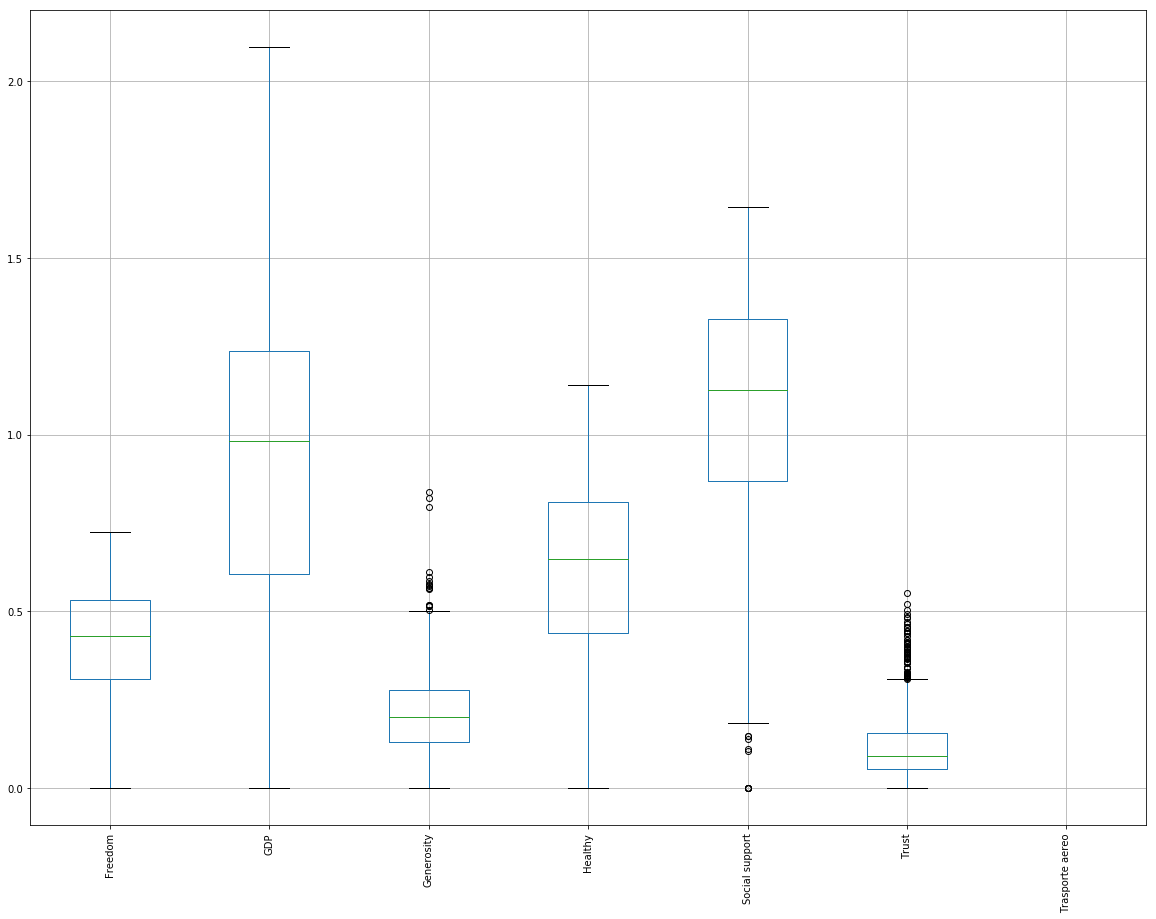

In [55]:
df.drop(columns=['Year','Dystopia Residual','Rank','Rounded Score','Score', 'Refugiados','Ratio dif empleo genero','Mujeres desempleadas.1524','Transporte aereo','Hombres mas 80','Mujeres desempleadas','Mujeres trab.servicios', 'Participación lab.1524','GDP por trabajador', 'Mujeres trab.agricultura']).boxplot()
plt.xticks(rotation=90)

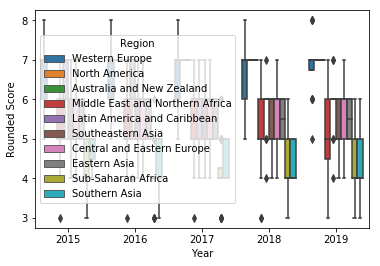

In [11]:
sns.boxplot(x="Year", y="Rounded Score", hue="Region", data=df)

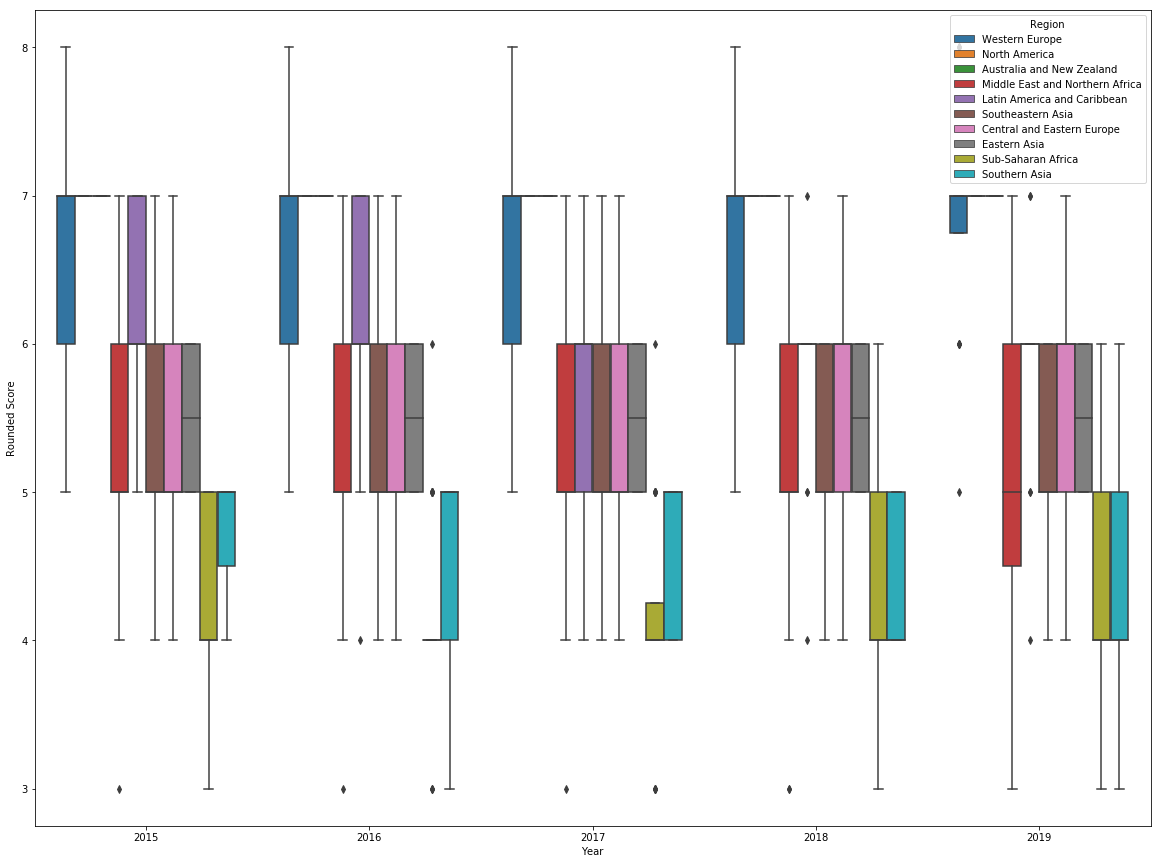

In [56]:
sns.boxplot(x="Year", y="Rounded Score", hue="Region", data=df)

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]), <a list of 10 Text xticklabel objects>)

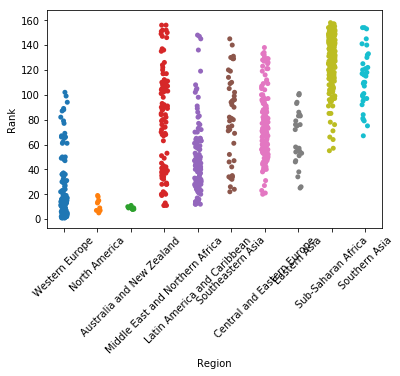

In [12]:
sns.stripplot(x="Region", y="Rank", data=df)
plt.xticks(rotation=45)

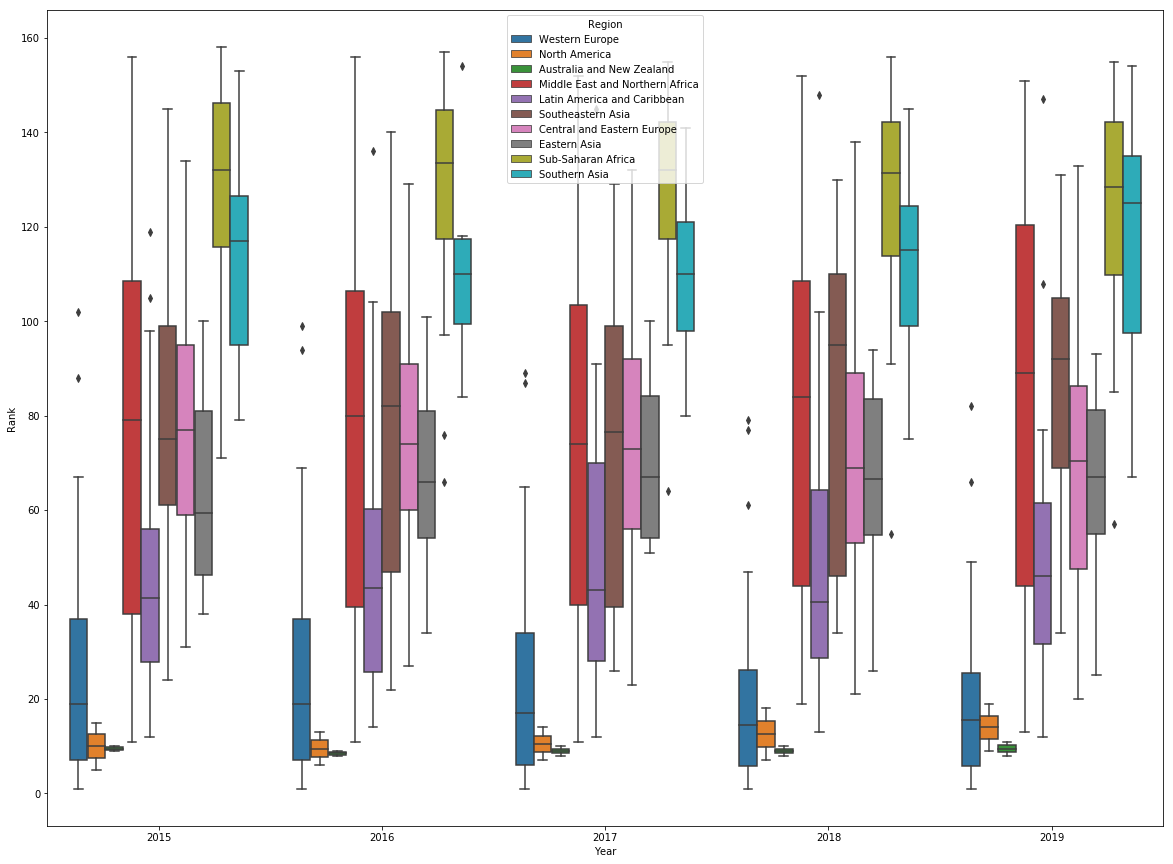

In [57]:
sns.boxplot(x="Year", y="Rank", hue="Region", data=df)

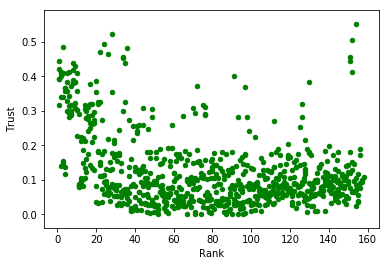

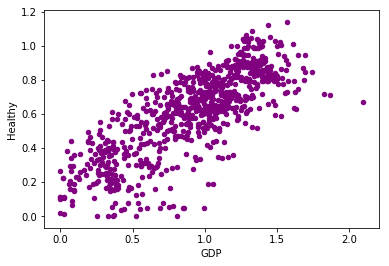

In [14]:
df.plot(kind='scatter', x='Rank', y='Trust',color = 'green')
df.plot(kind='scatter', x='GDP', y='Healthy',color = 'purple')

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]), <a list of 10 Text xticklabel objects>)

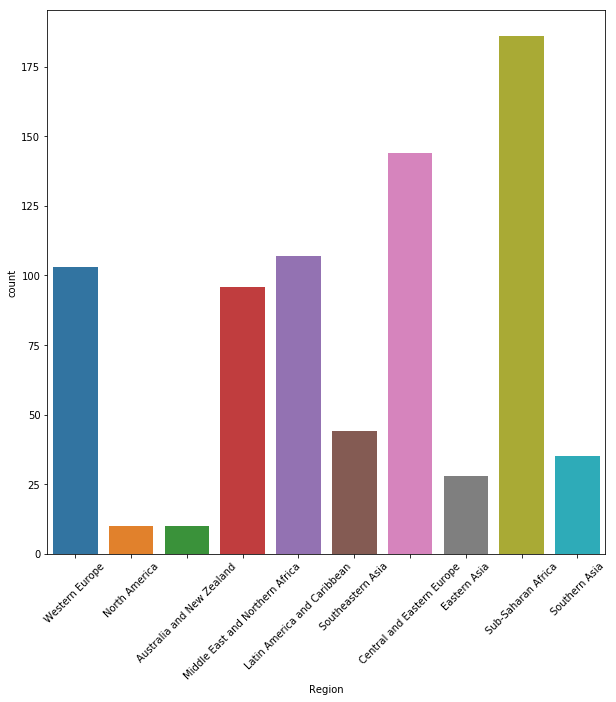

In [58]:
f,ax = plt.subplots(figsize =(10,10))
sns.countplot(df.Region)
plt.xticks(rotation= 45)

In [59]:
missing_values_count=df.isnull().sum()

missing_values_count

Country                        0
Dystopia Residual            312
Freedom                        0
GDP                            0
Generosity                     0
Healthy                        0
Rank                           0
Region                        19
Rounded Score                  0
Score                          0
Social support                 0
Trust                          1
Year                           0
Mujeres trab.agricultura     100
GDP por trabajador           100
Participación lab.1524       100
Mujeres trab.servicios       100
Mujeres desempleadas         100
Hombres mas 80               235
Trasporte aereo              782
Mujeres desempleadas.1524    100
Ratio dif empleo genero      100
Refugiados                   250
Transporte aereo             311
dtype: int64

In [18]:
'''Analises the nan points'''
for name in df.Region.unique():
    print(name);
    print(df.loc[df['Region'] == name].isnull().sum());
    print('----')

Western Europe
Country                        0
Dystopia Residual             40
Freedom                        0
GDP                            0
Generosity                     0
Healthy                        0
Rank                           0
Region                         0
Rounded Score                  0
Score                          0
Social support                 0
Trust                          0
Year                           0
Mujeres trab.agricultura       3
GDP por trabajador             3
Participación lab.1524         3
Mujeres trab.servicios         3
Mujeres desempleadas           3
Hombres mas 80                23
Trasporte aereo              103
Mujeres desempleadas.1524      3
Ratio dif empleo genero        3
Refugiados                    36
Transporte aereo              35
dtype: int64
----
North America
Country                       0
Dystopia Residual             4
Freedom                       0
GDP                           0
Generosity                    0
H

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f0bce90cc10>]],
      dtype=object)

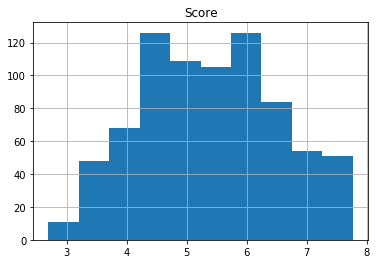

In [15]:
df.hist(column='Score')

## Preparación y modelado

In [60]:
# remplazo de valores nulos
df=df.replace(np.nan, "0")
df

Country Dystopia Residual  Freedom      GDP  Generosity  \
0                 Switzerland           2.51738  0.66557  1.39651     0.29678   
1                     Iceland           2.70201  0.62877  1.30232     0.43630   
2                     Denmark           2.49204  0.64938  1.32548     0.34139   
3                      Norway           2.46531  0.66973  1.45900     0.34699   
4                      Canada           2.45176  0.63297  1.32629     0.45811   
..                        ...               ...      ...      ...         ...   
777                    Rwanda                 0  0.55500  0.35900     0.21700   
778                  Tanzania                 0  0.41700  0.47600     0.27600   
779               Afghanistan                 0  0.00000  0.35000     0.15800   
780  Central African Republic                 0  0.22500  0.02600     0.23500   
781               South Sudan                 0  0.01000  0.30600     0.20200   

     Healthy  Rank              Region  Rounded Score  Score  ...  \
0    0.94143     1      Western Europe            8.0  7.587  ...   
1    0.94784     2      Western Europe            8.0  7.561  ...   
2    0.87464     3      Western Europe            8.0  7.527  ...   
3    0.88521     4      Western Europe            8.0  7.522  ...   
4    0.90563     5       North America            7.0  7.427  ...   
..       ...   ...                 ...            ...    ...  ...   
777  0.61400   152  Sub-Saharan Africa            3.0  3.334  ...   
778  0.49900   153  Sub-Saharan Africa            3.0  3.231  ...   
779  0.36100   154       Southern Asia            3.0  3.203  ...   
780  0.10500   155  Sub-Saharan Africa            3.0  3.083  ...   
781  0.29500   156                   0            3.0  2.853  ...   

     GDP por trabajador Participación lab.1524  Mujeres trab.servicios  \
0                103603                 68.313                  87.031   
1               75040.6                 81.785                   91.33   
2               94613.5                  62.39                  89.277   
3                125677                 56.618                   91.87   
4               84005.4                 64.449                  90.434   
..                  ...                    ...                     ...   
777             4223.94                 63.733                  25.662   
778             6497.99                 69.106                  29.461   
779              6984.9                 20.404                  10.079   
780             2048.33                 52.889                  15.996   
781             4464.73                 63.477                  18.926   

    Mujeres desempleadas Hombres mas 80 Trasporte aereo  \
0                  4.912        3.70526               0   
1                  4.051        3.02985               0   
2                  6.444        3.21888               0   
3                  3.999        3.12968               0   
4                  6.285         3.2708               0   
..                   ...            ...             ...   
777                 1.07              0               0   
778                2.462              0               0   
779               14.004              0               0   
780                3.565              0               0   
781               13.406              0               0   

    Mujeres desempleadas.1524 Ratio dif empleo genero Refugiados  \
0                        8.39                 84.0807         17   
1                       6.638                 90.3024          0   
2                      10.027                 86.8573          9   
3                       8.565                 89.6324         12   
4                      11.228                 86.2951         80   
..                        ...                     ...        ...   
777                     2.157                 100.685          0   
778                     4.179                 91.1001          0   
779       

### Objectivo 1

In [80]:
import scipy 

In [81]:
c1 = scipy.stats.pearsonr(df['Score'], df['GDP'])
c2 = scipy.stats.pearsonr(df['Score'], df['Social support'])
c3 = scipy.stats.pearsonr(df['Score'], df['Healthy'])
c4 = scipy.stats.pearsonr(df['Score'], df['Freedom'])
c5 = scipy.stats.pearsonr(df['Score'], df['Generosity'])
c6 = scipy.stats.pearsonr(df['Score'], df['Trust'])

print('Happiness Score + GDP: pearson = ', round(c1[0],2), '   pvalue = ', round(c1[1],4))
print('Happiness Score + Social support: pearson = ', round(c2[0],2), '   pvalue = ', round(c2[1],4))
print('Happiness Score + Healthy: pearson = ', round(c3[0],2), '   pvalue = ', round(c3[1],4))
print('Happiness Score + Freedom: pearson = ', round(c4[0],2), '   pvalue = ', round(c4[1],4))
print('Happiness Score + Generosity: pearson = ', round(c5[0],2), '   pvalue = ', round(c5[1],4))
print('Happiness Score + Trust: pearson = ', round(c6[0],2), '   pvalue = ', round(c6[1],4))

TypeError: unsupported operand type(s) for +: 'float' and 'str'

In [65]:
c1 = scipy.stats.pearsonr(df['Score'], df['Mujeres trab.agricultura'])
c2 = scipy.stats.pearsonr(df['Score'], df['Refugiados'])
c3 = scipy.stats.pearsonr(df['Score'], df['Hombres mas 80'])
c4 = scipy.stats.pearsonr(df['Score'], df['Mujeres trab.servicios'])
c5 = scipy.stats.pearsonr(df['Score'], df['Mujeres desempleadas'])
c6 = scipy.stats.pearsonr(df['Score'], df['Ratio dif empleo genero'])
c7 = scipy.stats.pearsonr(df['Score'], df['Participación lab.1524'])
                                          
print('Happiness Score + Mujeres trab.agricultura: pearson = ', round(c1[0],2), '   pvalue = ', round(c1[1],4))
print('Happiness Score + Refugiados: pearson = ', round(c2[0],2), '   pvalue = ', round(c2[1],4))
print('Happiness Score + Hombres mas 80: pearson = ', round(c3[0],2), '   pvalue = ', round(c3[1],4))
print('Happiness Score + Mujeres trab.servicios: pearson = ', round(c4[0],2), '   pvalue = ', round(c4[1],4))
print('Happiness Score + Mujeres desempleadas: pearson = ', round(c5[0],2), '   pvalue = ', round(c5[1],4))
print('Happiness Score + Ratio dif empleo genero: pearson = ', round(c6[0],2), '   pvalue = ', round(c6[1],4))
print('Happiness Score + Participación lab.1524: pearson = ', round(c7[0],2), '   pvalue = ', round(c7[1],4))

TypeError: unsupported operand type(s) for +: 'float' and 'str'

In [66]:
# Cuantas observaciones tenemos en cada región extayendo los 19 nan previamente encontrados (valor 0)
df.any(axis=1).groupby([df['Region']]).sum()

Region
0                                   19.0
Australia and New Zealand           10.0
Central and Eastern Europe         144.0
Eastern Asia                        28.0
Latin America and Caribbean        107.0
Middle East and Northern Africa     96.0
North America                       10.0
Southeastern Asia                   44.0
Southern Asia                       35.0
Sub-Saharan Africa                 186.0
Western Europe                     103.0
dtype: float64

In [67]:
'''Modelo regresion lineal todas las variables'''
# Definir la variable objetivo
data = pd.DataFrame(df, columns=['Freedom','GDP','Healthy','Generosity','Social support','Trust','Refugiados','Ratio dif empleo genero','Hombres mas 80','Mujeres desempleadas','Mujeres trab.servicios', 'Participación lab.1524', 'Mujeres trab.agricultura'])
y=df['Score']

# Hacemos la partición de los datos
X_train, X_test, y_train, y_test=train_test_split(data, y, test_size=0.20, random_state=42)

# Modelo de regresión lineal para conocer las variables más influyentes
regmodel=linear_model.LinearRegression()
regmodel=regmodel.fit(X_train, y_train)

# MSE y R2
y_pred=regmodel.predict(X_test)
print('Coefficients: \n', regmodel.coef_)
print('Mean squared error (MSE): %.2f' % mean_squared_error(y_test, y_pred))
print('R-cuadrado: %.2f' % r2_score(y_test, y_pred))

# Tabla coeficientes
pd.DataFrame(regmodel.coef_, X_train.columns, columns=['Coefficient'])

Coefficients: 
 [ 9.94041125e-01  7.46065270e-01  7.18622151e-01  1.63383819e-01
  6.48583305e-01  9.62788481e-01  3.43527295e-08 -1.11621702e-02
  7.72198209e-02 -2.62509408e-02  1.37536641e-02  6.22859592e-03
  3.27654420e-03]
Mean squared error (MSE): 0.29
R-cuadrado: 0.76


Coefficient
Freedom                   9.940411e-01
GDP                       7.460653e-01
Healthy                   7.186222e-01
Generosity                1.633838e-01
Social support            6.485833e-01
Trust                     9.627885e-01
Refugiados                3.435273e-08
Ratio dif empleo genero  -1.116217e-02
Hombres mas 80            7.721982e-02
Mujeres desempleadas     -2.625094e-02
Mujeres trab.servicios    1.375366e-02
Participación lab.1524    6.228596e-03
Mujeres trab.agricultura  3.276544e-03

In [68]:
'''Modelo de regresion lineal data set inicial'''
# Definir la variable objetivo
data1= pd.DataFrame(df, columns=['Freedom','GDP','Healthy','Generosity','Social support','Trust'])
y=df['Score']

# Hacemos la partición de los datos
X_train, X_test, y_train, y_test=train_test_split(data1, y, test_size=0.20, random_state=42)

# Modelo de regresión lineal para conocer las variables más influyentes
regmodel=linear_model.LinearRegression()
regmodel=regmodel.fit(X_train, y_train)

# MSE y R2
y_pred=regmodel.predict(X_test)
print('Coefficients: \n', regmodel.coef_)
print('Mean squared error (MSE): %.2f' % mean_squared_error(y_test, y_pred))
print('R-cuadrado: %.2f' % r2_score(y_test, y_pred))

# Tabla coeficientes
pd.DataFrame(regmodel.coef_, X_train.columns, columns=['Coefficient'])

Coefficients: 
 [1.47108943 1.06505169 1.0350344  0.47151684 0.66104588 1.19011302]
Mean squared error (MSE): 0.33
R-cuadrado: 0.73


Coefficient
Freedom            1.471089
GDP                1.065052
Healthy            1.035034
Generosity         0.471517
Social support     0.661046
Trust              1.190113

In [69]:
'''Modelo con regresion lineal con variables externas'''
data2 = pd.DataFrame(df, columns=['Refugiados','Hombres mas 80','Mujeres trab.servicios', 'Participación lab.1524', 'Mujeres trab.agricultura','Mujeres desempleadas','Ratio dif empleo genero'])
y=df['Score']

data2.head()

# Hacemos la partición de los datos nuevamente con las nuevas variables
X_train, X_test, y_train, y_test=train_test_split(data2, y, test_size=0.20, random_state=42)
regmodel2=linear_model.LinearRegression()
regmodel2=regmodel2.fit(X_train, y_train)

# MSE y R2
y_pred=regmodel2.predict(X_test)
print('Coefficients: \n', regmodel2.coef_)
print('Mean squared error (MSE): %.2f' % mean_squared_error(y_test, y_pred))
print('R-cuadrado: %.2f' % r2_score(y_test, y_pred))

# Tabla coeficientes
pd.DataFrame(regmodel2.coef_, X_train.columns, columns=['Coefficient'])

Coefficients: 
 [-3.94552546e-08  1.54605899e-01  2.72162705e-02  1.34282077e-02
 -6.22544303e-03 -4.99820020e-02 -1.87284273e-02]
Mean squared error (MSE): 0.52
R-cuadrado: 0.57


Coefficient
Refugiados               -3.945525e-08
Hombres mas 80            1.546059e-01
Mujeres trab.servicios    2.721627e-02
Participación lab.1524    1.342821e-02
Mujeres trab.agricultura -6.225443e-03
Mujeres desempleadas     -4.998200e-02
Ratio dif empleo genero  -1.872843e-02

In [70]:
# Regresion linial aplicada a regiones con los coeficientes mas correlacionados de WDI dataset
df_weurope = df.loc[df['Region'] == 'Western Europe'].replace(np.nan, 0)
data = pd.DataFrame(df_weurope, columns=['Refugiados','Ratio dif empleo genero','Mujeres desempleadas.1524','Hombres mas 80','Mujeres desempleadas','Mujeres trab.servicios', 'Participación lab.1524', 'Mujeres trab.agricultura','Ratio dif empleo genero','Transporte aereo'])
y=df_weurope['Score']
X_train, X_test, y_train, y_test=train_test_split(data, y, test_size=0.20, random_state=42)
regmodel=linear_model.LinearRegression()
regmodel=regmodel.fit(X_train, y_train)
y_pred=regmodel.predict(X_test)
print('Coefficients: \n', regmodel.coef_)
print('Mean squared error (MSE): %.2f' % mean_squared_error(y_test, y_pred))
print('R-cuadrado: %.2f' % r2_score(y_test, y_pred))
pd.DataFrame(regmodel.coef_, X_train.columns, columns=['Coefficient'])

Coefficients: 
 [ 1.19241606e-04  9.64302974e-03 -2.35321886e-02  9.39127608e-03
  2.06645699e-02 -8.64679252e-03  1.54042142e-02 -1.02032536e-01
  9.64302974e-03 -1.20999644e-07]
Mean squared error (MSE): 0.26
R-cuadrado: 0.55


Coefficient
Refugiados                 1.192416e-04
Ratio dif empleo genero    9.643030e-03
Mujeres desempleadas.1524 -2.353219e-02
Hombres mas 80             9.391276e-03
Mujeres desempleadas       2.066457e-02
Mujeres trab.servicios    -8.646793e-03
Participación lab.1524     1.540421e-02
Mujeres trab.agricultura  -1.020325e-01
Ratio dif empleo genero    9.643030e-03
Transporte aereo          -1.209996e-07

In [71]:
# Regresion linial aplicada a regiones con los coeficientes mas correlacionados de WDI dataset
df_america = df.loc[df['Region'] == 'North America'].replace(np.nan, 0)
data = pd.DataFrame(df_america, columns=['Refugiados','Ratio dif empleo genero','Mujeres desempleadas','Hombres mas 80','Participación lab.1524'])
y=df_america['Score']
X_train, X_test, y_train, y_test=train_test_split(data, y, test_size=0.20, random_state=42)
regmodel=linear_model.LinearRegression()
regmodel=regmodel.fit(X_train, y_train)
y_pred=regmodel.predict(X_test)
print('Coefficients: \n', regmodel.coef_)
print('Mean squared error (MSE): %.2f' % mean_squared_error(y_test, y_pred))
print('R-cuadrado: %.2f' % r2_score(y_test, y_pred))
pd.DataFrame(regmodel.coef_, X_train.columns, columns=['Coefficient'])

Coefficients: 
 [-6.13420841e-06  4.85658587e-02  2.32145051e-01 -1.52714057e-02
 -1.86177114e-02]
Mean squared error (MSE): 0.00
R-cuadrado: 0.80


Coefficient
Refugiados                 -0.000006
Ratio dif empleo genero     0.048566
Mujeres desempleadas        0.232145
Hombres mas 80             -0.015271
Participación lab.1524     -0.018618

### Objetivo 2

In [17]:
from sklearn.linear_model import Ridge
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LinearRegression

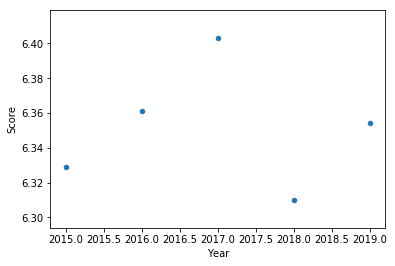

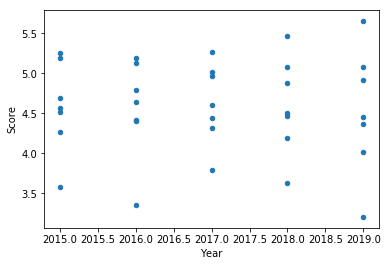

In [19]:
# Vemos que no tiene sentido hacer regresion por pais o por región.
df.loc[df['Country'] == 'Spain'].plot.scatter(x='Year', y='Score')
df.loc[df['Region'] == 'Southern Asia'].plot.scatter(x='Year', y='Score')

In [20]:
# Regresion linial con los coeficientes mas correlacionados de WDI dataset
df_america = df.loc[df['Region'] == 'North America'].replace(np.nan, 0)
data = pd.DataFrame(df_america, columns=['Refugiados','Ratio dif empleo genero','Mujeres desempleadas.1524','Hombres mas 80','Mujeres desempleadas','Mujeres trab.servicios', 'Participación lab.1524', 'Mujeres trab.agricultura'])
y=df_america['Score']

X_train, X_test, y_train, y_test=train_test_split(data, y, test_size=0.20, random_state=42)
regmodel=linear_model.LinearRegression()
regmodel=regmodel.fit(X_train, y_train)
y_pred=regmodel.predict(X_test)
print('Coefficients: \n', regmodel.coef_)
print('Mean squared error (MSE): %.2f' % mean_squared_error(y_test, y_pred))
print('R-cuadrado: %.2f' % r2_score(y_test, y_pred))
pd.DataFrame(regmodel.coef_, X_train.columns, columns=['Coefficient'])

Coefficients: 
 [-2.33549512e-05 -2.87601733e-01  2.26238617e-01  1.21186892e-01
 -4.66257586e-01  3.27237757e+00  1.21771739e-01  1.82512803e+00]
Mean squared error (MSE): 0.12
R-cuadrado: -18.38


Coefficient
Refugiados                   -0.000023
Ratio dif empleo genero      -0.287602
Mujeres desempleadas.1524     0.226239
Hombres mas 80                0.121187
Mujeres desempleadas         -0.466258
Mujeres trab.servicios        3.272378
Participación lab.1524        0.121772
Mujeres trab.agricultura      1.825128

In [21]:
# Regresion linial con los coeficientes mas correlacionados de WDI dataset
df_america = df.loc[df['Region'] == 'North America'].replace(np.nan, 0)
data = pd.DataFrame(df_america, columns=['Refugiados','Ratio dif empleo genero','Mujeres desempleadas','Hombres mas 80','Participación lab.1524'])
y=df_america['Score']

X_train, X_test, y_train, y_test=train_test_split(data, y, test_size=0.20, random_state=42)
regmodel=linear_model.LinearRegression()
regmodel=regmodel.fit(X_train, y_train)
y_pred=regmodel.predict(X_test)
print('Coefficients: \n', regmodel.coef_)
print('Mean squared error (MSE): %.2f' % mean_squared_error(y_test, y_pred))
print('R-cuadrado: %.2f' % r2_score(y_test, y_pred))
pd.DataFrame(regmodel.coef_, X_train.columns, columns=['Coefficient'])

Coefficients: 
 [-6.13420841e-06  4.85658587e-02  2.32145051e-01 -1.52714057e-02
 -1.86177114e-02]
Mean squared error (MSE): 0.00
R-cuadrado: 0.80


Coefficient
Refugiados                 -0.000006
Ratio dif empleo genero     0.048566
Mujeres desempleadas        0.232145
Hombres mas 80             -0.015271
Participación lab.1524     -0.018618

### objetivo 2

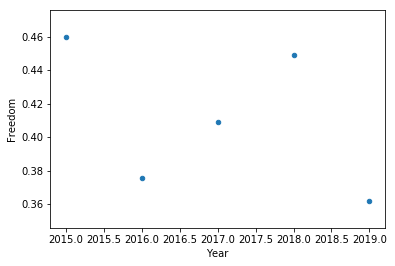

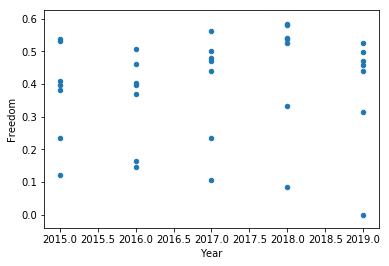

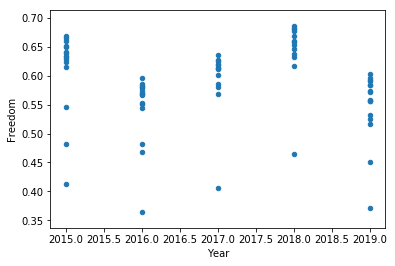

In [22]:
df.loc[df['Country'] == 'Spain'].plot.scatter(x='Year', y='Freedom')
df.loc[df['Region'] == 'Southern Asia'].plot.scatter(x='Year', y='Freedom')
df.loc[df['Score'] > 7 ].plot.scatter(x='Year', y='Freedom')


Social support
0.37481504116002173
Trust
0.0017006367022192048
Freedom
0.0027466049277473648
GDP
0.002387120273264376
Generosity
0.07002712946141498
Healthy
0.2778045517105586


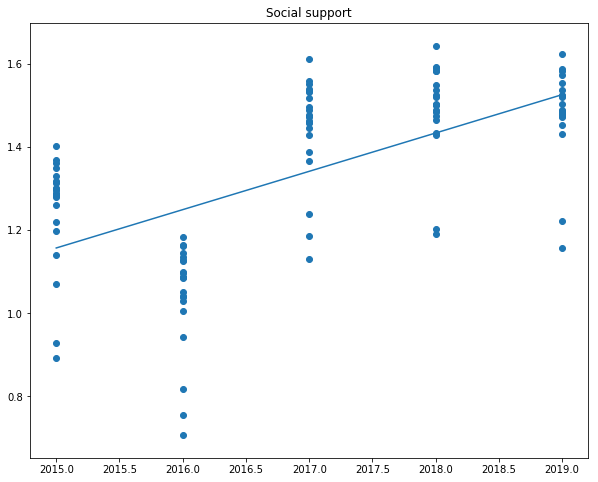

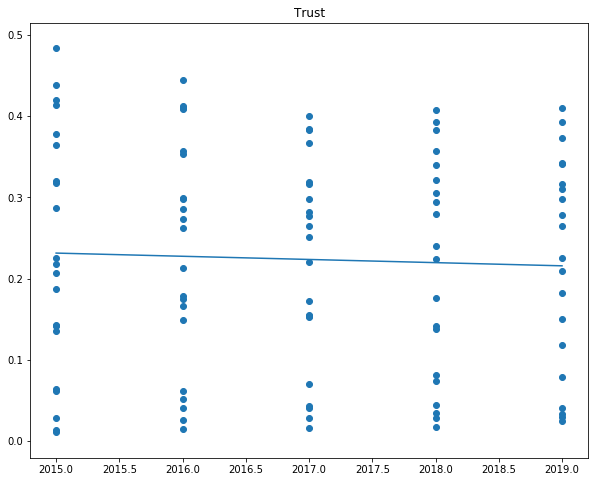

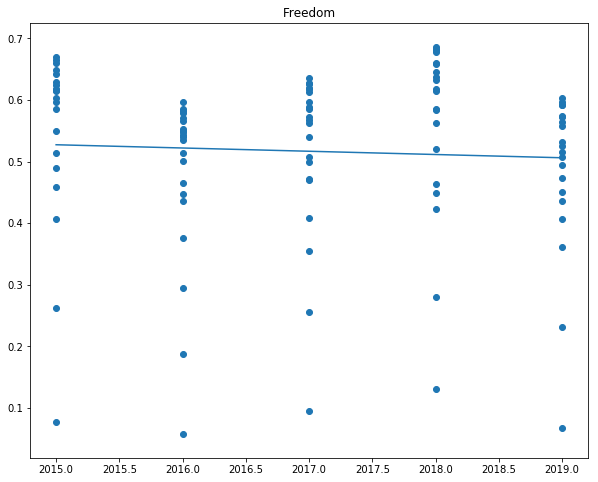

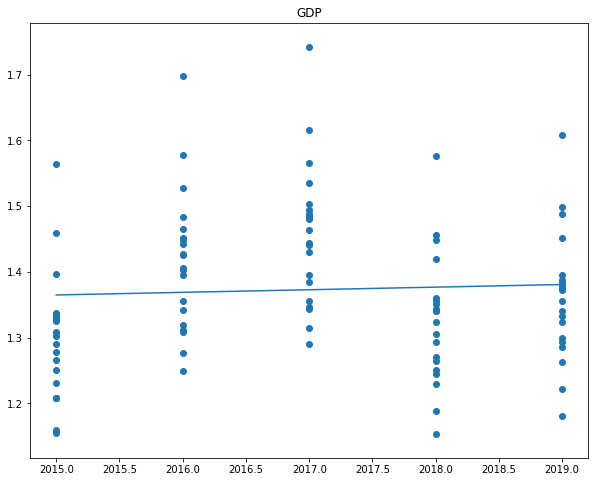

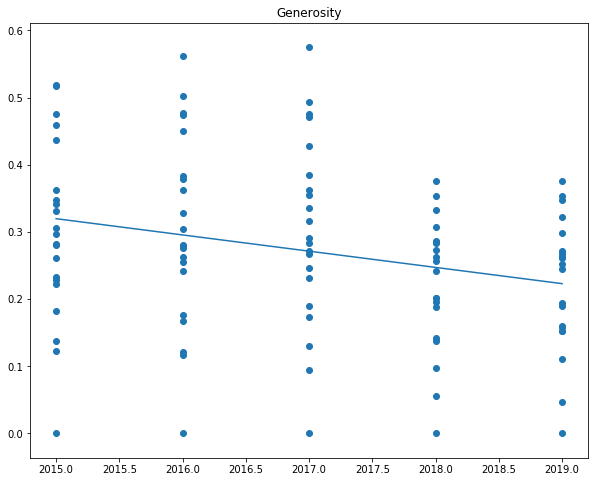

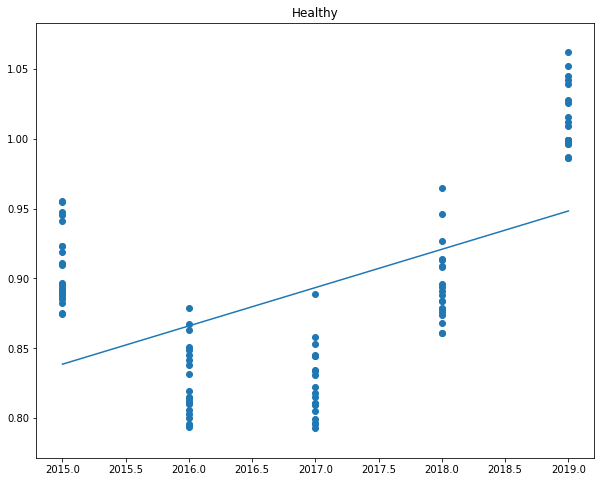

In [23]:
fields = ['Social support', 'Trust', 'Freedom', 'GDP', 'Generosity', 'Healthy']
# Aqui no tiene sentido hacer samples de train y test.
#data = df.loc[df['Score'] < 4]
#data = df.loc[df['Region'] == 'North America']
data = df.loc[df['Region'] == 'Western Europe'].replace(np.nan, 0)

x = data['Year'].values.reshape(-1,1)

for field in fields:
    print(field)
    y =data[field].values.reshape(-1,1)
    regmodel=linear_model.LinearRegression().fit(x, y)
    y_pred=regmodel.predict(x)
    plt.figure(figsize=(10,8));
    plt.title(field)
    plt.scatter(x, y);
    plt.plot(x, y_pred);
    print(r2_score(y, y_pred))

In [74]:
EUcountries = pd.read_csv('data/EU.csv')
EUcountries
df2=df
df2 = df.join(EUcountries.set_index('Country')['EU'], on='Country',how='left', rsuffix='_right')  

0.0064931592990769005
[0.45599203]
0.010245460683470986
[1.72338408]
0.127692949584865
[2.59643647]
0.04426336260018038
[2.72698589]
0.37657241058661794
[4.31713893]
0.00019096634879733898
[4.42451305]
0.011652930747288681
[6.17343218]
         Score
Year          
2015  5.857067
2016  5.920400
2017  6.017000
2018  6.144067
2019  6.258733


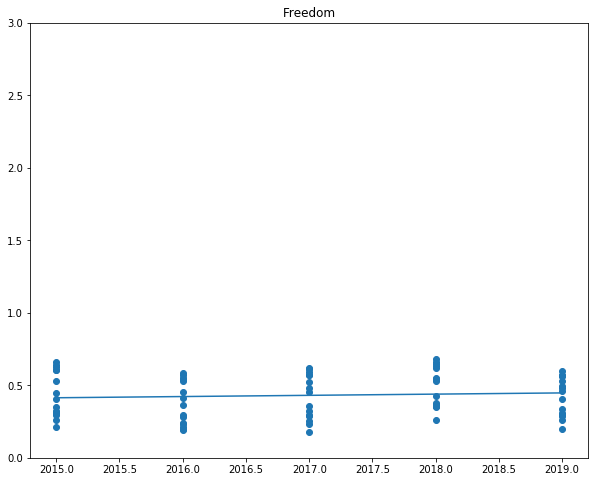

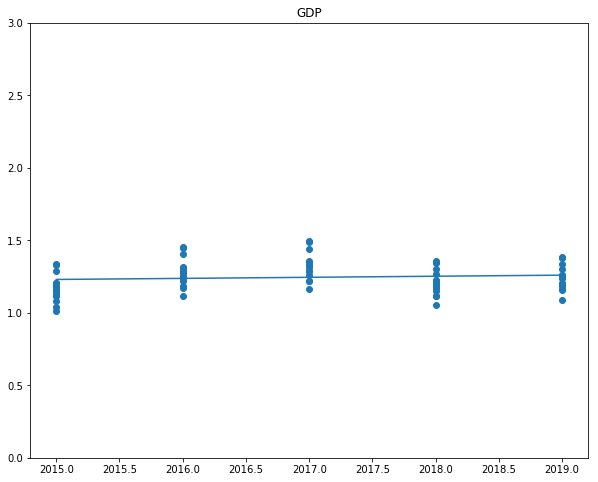

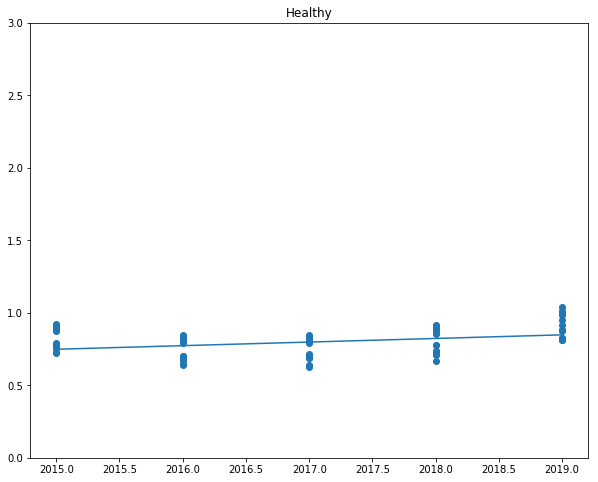

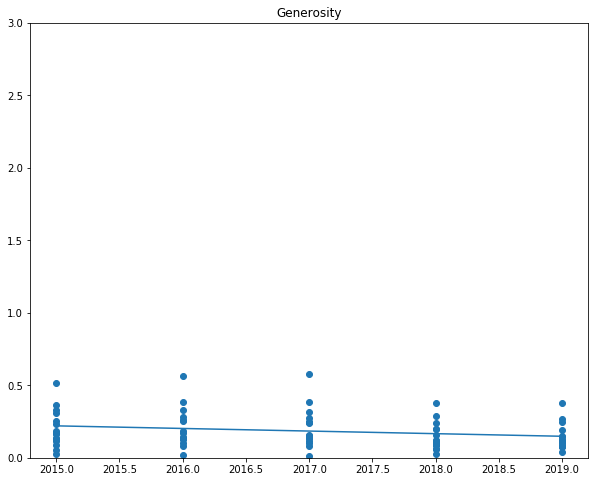

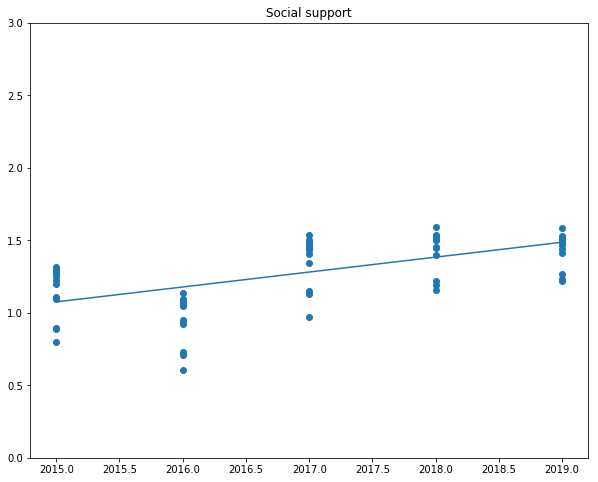

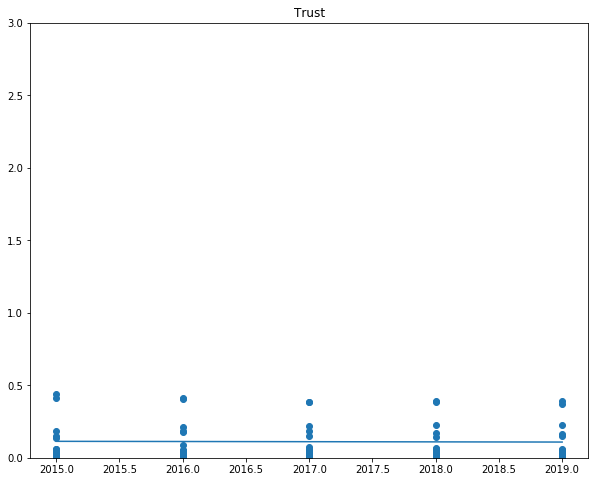

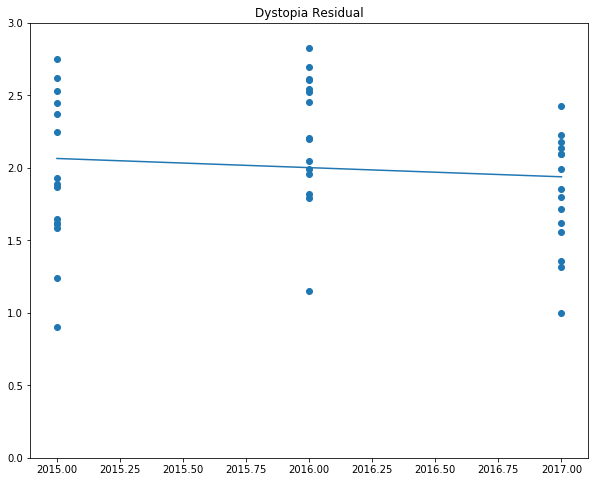

In [75]:
'''# EU90, EUPOST90 & EU'''
# Definimos los parámetros a estudiar del dataset inicial
Parameters = ['Freedom','GDP','Healthy','Generosity','Social support','Trust'] 

#Definimos el dataset a tratar ('EUPOST90', 'EU90')
#dataEU = df2.loc[(df2['EU'] == 'EU90') | (df2['EU'] == 'EUPOST90')]
#dataEU = df2.loc[(df2['EU'] == 'EU90')]
dataEU = df2.loc[(df2['EU'] == 'EUPOST90')]

#Ponemos el Score a 0
prediction=0

#Iteramos para cada parámetro
for i in Parameters:
    y = dataEU[i].values.reshape(-1,1)
    x = dataEU['Year'].values.reshape(-1,1)
    regmodel=linear_model.LinearRegression().fit(x, y)
    y_pred=regmodel.predict(x)
    plt.figure(figsize=(10,8));
    plt.scatter(x, y);
    plt.ylim((0,3));
    plt.title(i);
    plt.plot(x, y_pred);
    print(r2_score(y, y_pred))   
    coef=regmodel.coef_
    inte=regmodel.intercept_
    prediction=coef[0]*2020+inte[0]+prediction
    print(prediction)

#Creamos otro dataframe con los 3 primeros años, que son los que tienen Dystopia
dataEU2=dataEU.loc[(dataEU['Year'] == 2015) | (dataEU['Year'] == 2016) | (dataEU['Year'] == 2017)]

#Calculamos la regresión para la Dystopia
y = dataEU2['Dystopia Residual'].values.reshape(-1,1)
x = dataEU2['Year'].values.reshape(-1,1)
regmodel=linear_model.LinearRegression().fit(x, y)
y_pred=regmodel.predict(x)

plt.figure(figsize=(10,8));
plt.scatter(x, y);
plt.ylim((0,3));
plt.title('Dystopia Residual')
plt.plot(x, y_pred);
print(r2_score(y, y_pred))
coef=regmodel.coef_
inte=regmodel.intercept_
prediction=coef[0]*2020+inte[0]+prediction
print(prediction)

Avgscore=dataEU.groupby(['Year']).agg({'Score': np.mean})
print(Avgscore)



In [77]:
'''TOP & BOTTOM 5'''
#Hacemos la media de los Scores y nos quedamos con el TOP o Bottom 5
CountriesScore=df2.groupby(['Country']).agg({'Score': np.mean})
TOP5Score=CountriesScore.nlargest(5,'Score')
#TOP5Score
TOP5List=['Denmark','Norway','Finland','Switzerland','Iceland']
BOTTOM5Score=CountriesScore.nsmallest(5,'Score')
#BOTTOM5Score
BOTTOM5List=['Burundi','Central African Republic','Syria','South Sudan','Rwanda']

[0.17563854]
[0.46489493]
[0.76045221]
[0.97919767]
[1.47460439]
[1.61286966]
[3.17658749]
        Score
Year         
2015  3.26350
2016  3.33025
2017  3.22440
2018  3.22240
2019  3.30140


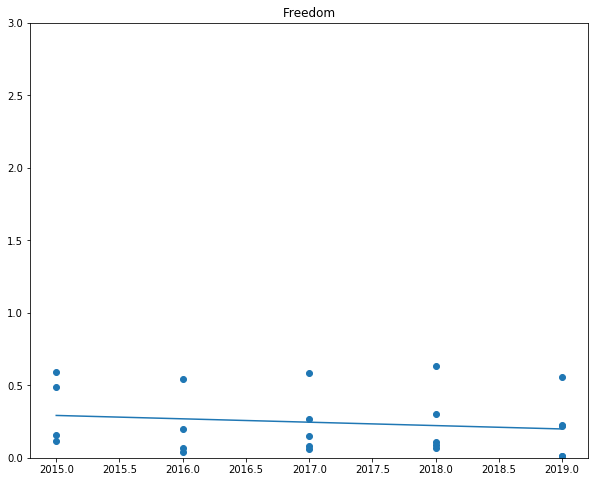

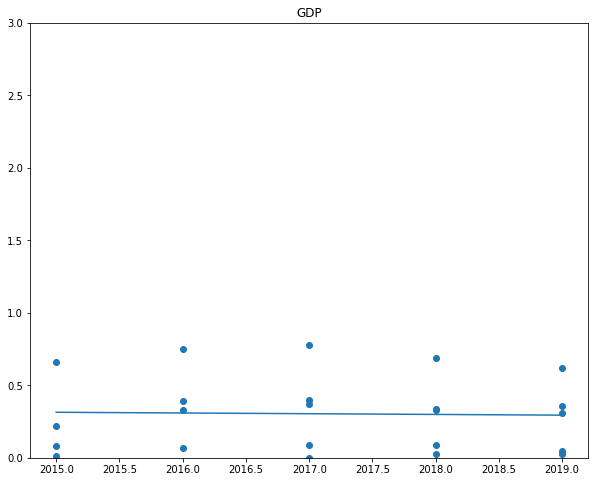

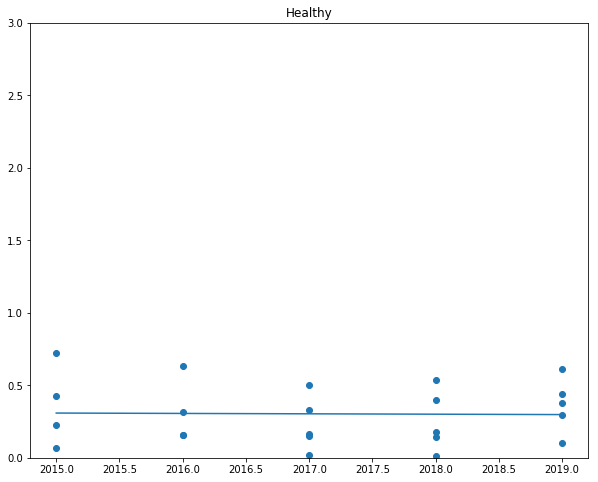

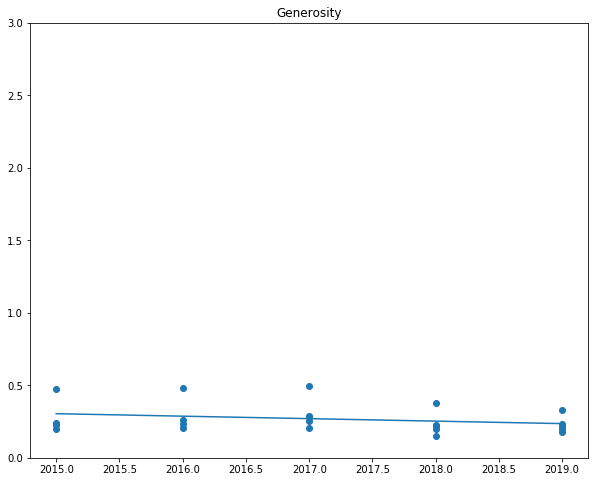

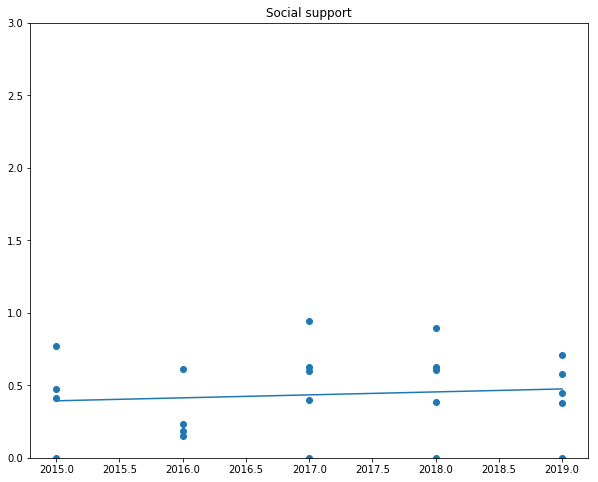

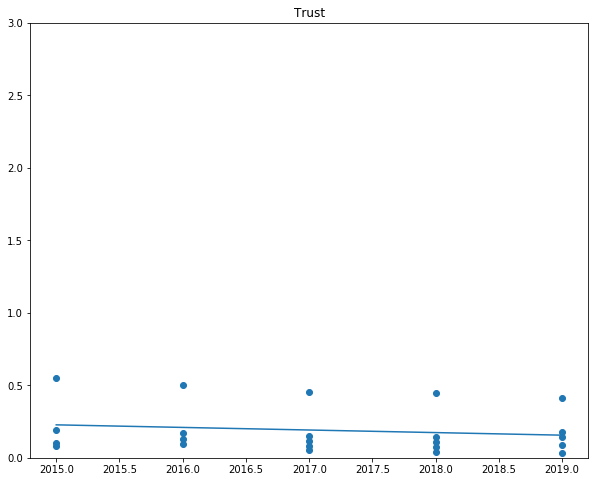

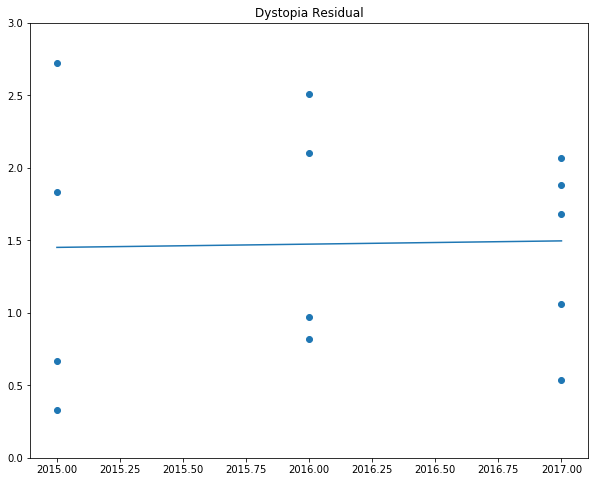

In [78]:
# Definimos los parámetros a estudiar del dataset inicial
Parameters = ['Freedom','GDP','Healthy','Generosity','Social support','Trust'] 

#Definimos el dataset a tratar ('TOP5' o 'BOTTOM5')
#dataTOP5orBOTTOM5 = df2.loc[(df2['Country'] == 'Denmark') | (df2['Country'] == 'Norway') | (df2['Country'] == 'Finland') | (df2['Country'] == 'Switzerland') | (df2['Country'] == 'Iceland')]
dataTOP5orBOTTOM5 = df2.loc[(df2['Country'] == 'Burundi') | (df2['Country'] == 'Central African Republic') | (df2['Country'] == 'Syria') | (df2['Country'] == 'South Sudan') | (df2['Country'] == 'Rwanda')]

#Ponemos el Score a 0
prediction=0

#Iteramos para cada parámetro
for i in Parameters:
    y = dataTOP5orBOTTOM5[i].values.reshape(-1,1)
    x = dataTOP5orBOTTOM5['Year'].values.reshape(-1,1)
    regmodel=linear_model.LinearRegression().fit(x, y)
    y_pred=regmodel.predict(x)
    plt.figure(figsize=(10,8));
    plt.scatter(x, y);
    plt.ylim((0,3));
    plt.title(i);
    plt.plot(x, y_pred);
#    print(r2_score(y, y_pred))
#    print('Coefficients: \n', regmodel.coef_)
#    print('Intercept: \n', regmodel.intercept_)
    
    coef=regmodel.coef_
    inte=regmodel.intercept_
    prediction=coef[0]*2020+inte[0]+prediction
    print(prediction)
#    print(prediction)
#    print(coef*2020+inte)

#Creamos otro dataframe con los 3 primeros años, que son los que tienen Dystopia
dataTOP5orBOTTOM52=dataTOP5orBOTTOM5.loc[(dataTOP5orBOTTOM5['Year'] == 2015) | (dataTOP5orBOTTOM5['Year'] == 2016) | (dataTOP5orBOTTOM5['Year'] == 2017)]

#Calculamos la regresión para la Dystopia
y = dataTOP5orBOTTOM52['Dystopia Residual'].values.reshape(-1,1)
x = dataTOP5orBOTTOM52['Year'].values.reshape(-1,1)
regmodel=linear_model.LinearRegression().fit(x, y)
y_pred=regmodel.predict(x)

plt.figure(figsize=(10,8));
plt.scatter(x, y);
plt.ylim((0,3));
plt.title('Dystopia Residual')
plt.plot(x, y_pred);
#print(r2_score(y, y_pred))
#print('Coefficients: \n', regmodel.coef_)
#print('Intercept: \n', regmodel.intercept_)

coef=regmodel.coef_
inte=regmodel.intercept_
prediction=coef[0]*2020+inte[0]+prediction
print(prediction)

Avgscore=dataTOP5orBOTTOM5.groupby(['Year']).agg({'Score': np.mean})
print(Avgscore)


### Objetivo 3

In [24]:
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import Ridge
from sklearn.preprocessing import PolynomialFeatures
from sklearn import linear_model


R2 score:
0.9804837828644817

Prediccion 2020
[[82.94545581]]
Prediccion 2021
[[82.74056757]]
Prediccion 2022
[[82.32466598]]


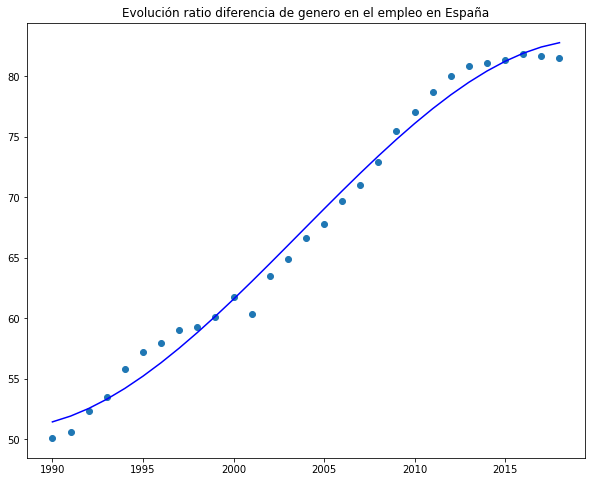

In [25]:
# Dif gen empleo
diff_gen = edf.loc[(edf['Country Name'] == 'Spain') & (edf['Indicator Code'] == 'SL.TLF.CACT.FM.ZS')]
# Previo a 1990 no hay datos
var_arr = []
for i in range(1990, 2019):
    var_arr.append(float(diff_gen[str(i)]))


var_df = pd.DataFrame({'Year': range(1990, 2019), 'diff_gen': var_arr})

x = var_df['Year'].values.reshape(-1,1)
y =var_df['diff_gen'].values.reshape(-1,1)

regmodel=linear_model.LinearRegression().fit(x, y)
y_pred=regmodel.predict(x)

poly_reg = PolynomialFeatures(degree=4)
X_poly = poly_reg.fit_transform(x)
pol_reg = LinearRegression()
pol_reg.fit(X_poly, y)

plt.figure(figsize=(10,8));
plt.title('Evolución ratio diferencia de genero en el empleo en España')
plt.scatter(x, y);
#plt.plot(x, y_poly_pred);
plt.plot(x, pol_reg.predict(poly_reg.fit_transform(x)), color='blue')
print('R2 score:')
print(r2_score(y, y_pred))
print()
print('Prediccion 2020')
print(pol_reg.predict(poly_reg.fit_transform([[2020]])))
print('Prediccion 2021')
print(pol_reg.predict(poly_reg.fit_transform([[2021]])))
print('Prediccion 2022')
print(pol_reg.predict(poly_reg.fit_transform([[2022]])))


R2 score:
0.9590565394667769

Prediccion 2020
[[89.10272799]]
Prediccion 2021
[[88.84440661]]
Prediccion 2022
[[88.49026116]]


'\nfor i in range(1960,2019):\n  print(i)\n  print(var[str(i)])\n'

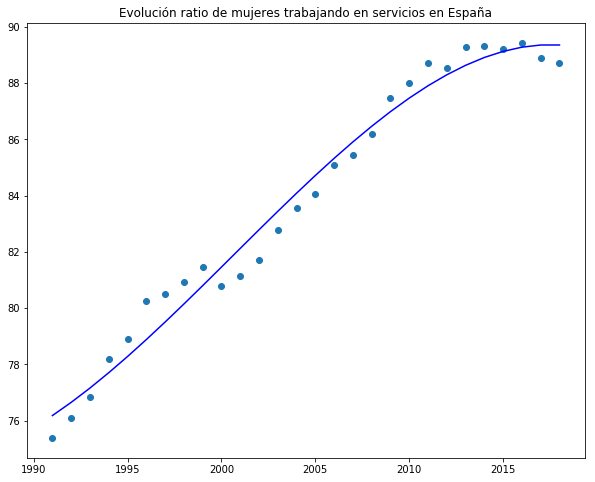

In [26]:
# Muj trab serv
var = edf.loc[(edf['Country Name'] == 'Spain') & (edf['Indicator Code'] == 'SL.SRV.EMPL.FE.ZS')]

# Previo a 1990 no hay datos
var_arr = []
for i in range(1991, 2019):
    var_arr.append(float(var[str(i)]))


var_df = pd.DataFrame({'Year': range(1991, 2019), 'var': var_arr})

x = var_df['Year'].values.reshape(-1,1)
y =var_df['var'].values.reshape(-1,1)

regmodel=linear_model.LinearRegression().fit(x, y)
y_pred=regmodel.predict(x)

poly_reg = PolynomialFeatures(degree=4)
X_poly = poly_reg.fit_transform(x)
pol_reg = LinearRegression()
pol_reg.fit(X_poly, y)

plt.figure(figsize=(10,8));
plt.title('Evolución ratio de mujeres trabajando en servicios en España')
plt.scatter(x, y);
#plt.plot(x, y_poly_pred);
plt.plot(x, pol_reg.predict(poly_reg.fit_transform(x)), color='blue')
print('R2 score:')
print(r2_score(y, y_pred))
print()
print('Prediccion 2020')
print(pol_reg.predict(poly_reg.fit_transform([[2020]])))
print('Prediccion 2021')
print(pol_reg.predict(poly_reg.fit_transform([[2021]])))
print('Prediccion 2022')
print(pol_reg.predict(poly_reg.fit_transform([[2022]])))
'''
for i in range(1960,2019):
  print(i)
  print(var[str(i)])
'''


R2 score:
0.9273948892259651

Prediccion 2020
[32.3291199]
Prediccion 2021
[33.36534069]
Prediccion 2022
[34.59629396]


'\nfor i in range(1960,2019):\n  print(i)\n  print(var[str(i)])\n'

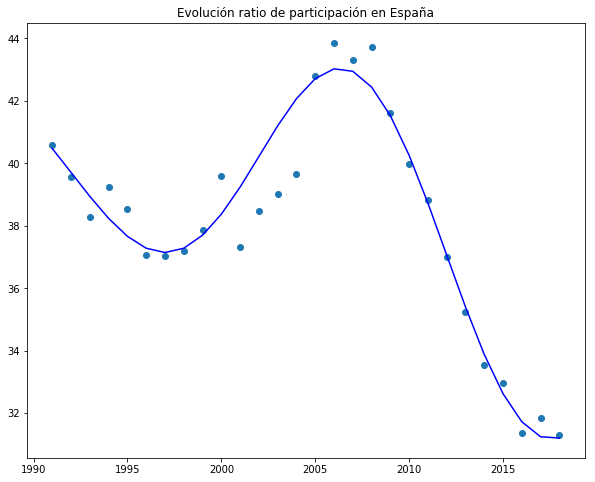

In [49]:
from sklearn.svm import SVR

# participación
var = edf.loc[(edf['Country Name'] == 'Spain') & (edf['Indicator Code'] == 'SL.TLF.ACTI.1524.FE.ZS')]

# Previo a 1990 no hay datos
var_arr = []
for i in range(1991, 2019):
    var_arr.append(float(var[str(i)]))

var_df = pd.DataFrame({'Year': range(1991, 2019), 'var': var_arr})

x = var_df['Year'].values.reshape(-1,1)
y =var_df['var'].values

poly_reg =  SVR(kernel='rbf', C=100, gamma=0.007, epsilon=.1)
#poly_reg =  SVR(kernel='poly', C=1, gamma='auto', degree=3, epsilon=.1, coef0=1)
#X_poly = poly_reg.fit_transform(x)
X_poly = poly_reg.fit(x,y)
pol_reg = LinearRegression()
#pol_reg.fit(X_poly, y)
pol_reg.fit(x, y)

plt.figure(figsize=(10,8));
plt.title('Evolución ratio de participación en España')
plt.scatter(x, y);
#plt.plot(x, y_poly_pred);
y_pred = poly_reg.predict(x)
plt.plot(x, y_pred, color='blue')
print('R2 score:')
print(r2_score(y, y_pred))
print()
print('Prediccion 2020')
print(poly_reg.predict([[2020]]))
print('Prediccion 2021')
print(poly_reg.predict([[2021]]))
print('Prediccion 2022')
print(poly_reg.predict([[2022]]))
'''
for i in range(1960,2019):
  print(i)
  print(var[str(i)])
'''
